<a name ="top"></a>
# Presidential Trends

We have access to all the US Presidential Speeches from April 1789 to Dec 2020. Presidential speeches are an opportunity for Presidents to set the tone of the country, put forth their agenda, influence policy and sway public opinion. 

We are going to use focus on the State of the Union Address (formerly Annual Message) and Inaugural Addresses to:
1. Look at trends in Presidential Speeches over time
2. Gain in sight into how geopolitical priorities changed with time.


Source data: https://www.kaggle.com/littleotter/united-states-presidential-speeches

# Major Findings
## Talk is cheap
1.  **The most popular presidents are the briefest orators!**
2. The number of words per sentence is decreasing over time i.e. there is a trend of Presidents using shorter sentences 
3. Oral speeches got longer when they stopped relying on written speeches. Not just more words, but more sentences.


## American Geopolitical Priorities
I compared the frequency of geo-related entities between Obama and Trump and found differences in the following using a synamic bard chart:
- America vs United States
- Ukraine vs Russia
- Middle East vs Asia
- Global Priorities vs Domestic Priorities

# TABLE OF CONTENTS

[Go to top](#top)

PART A. [DATA PREPARATION](#step0)  
[Step i: Import Libraries and Load and Prepare the Data](#stepi)  
[Step ii: Curate Dataset](#stepii)  
[Step iii: Data Labelling](#stepiii)  
[Step iv: Data Cleaning Strategy](#stepiv)

PART B. [RESULTS](#stepb)  
B1. [About the dataset](#stepb1)  
B2. [Number of Speeches per President](#stepb2)  
B3. [Written Speeches vs Oral Speeches](#stepb3)  
B4. [Number of Words in Presidential Speeches](#stepb4)  
B5. [Presidents with the longest and shortest speeches](#stepb5)  
B6. [Number of Sentences in Presidential Speeches](#stepb6)  
B7. [Trend in Words per Sentence over time in Presidential Speeches](#stepb7)


PART C. [NAME ENTITY RECOGINITION](#stepc)  
1. [Installing spaCy](#step1)
2. [Import spaCy](#step2)
3. [Named Entity Recognition](#step3)
4. [Bar Chart Race](#step4)

<a name =step0></a>
# PART A - EXPLORING THE DATASET

[Go to top](#top)

<a name =stepi></a>
    
# Step i: Import Libraries and Load and Prepare the Data

[Go to top](#top)

In [470]:
#import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
import numpy as np

from io import StringIO

#from re import sub

from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
#from nltk.corpus import stopwords

#from sklearn import svm
#from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer

#from sklearn.pipeline import Pipeline

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import collections
from collections import Counter

from datetime import datetime

In [7]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Upload Files

The speeches from Truman, Eisenhower, Rooselvelt, Trump were missing from the corpus and were added via the missing_speeches.csv as coallated from source: https://www.presidency.ucsb.edu/documents/app-categories/spoken-addresses-and-remarks/presidential/state-the-union-addresses?page=6

In [471]:
#upload csv files
corpus_df = pd.read_csv('corpus.csv')
presidential_speeches_df = pd.read_csv('presidential_speeches.csv')
missing_speeches_df = pd.read_csv('missing_speeches.csv')
#Append missing speeches by Thomas Jefferson, Franklin D. Rooselvelt, Harry S. Truman, Dwight Eisenhower and George W. Bush
presidential_speeches_df=presidential_speeches_df.append(missing_speeches_df, ignore_index=True)
#rename unnamed column name to President
corpus_df.rename(columns={"Unnamed: 0" :"President"}, inplace=True)
corpus_df.head()
#Assign Popularity and Wartime Categories

,President,Party,transcripts
0,George Washington,Unaffiliated,Fellow Citizens of the Senate and the House of...
1,John Adams,Federalist,"When it was first perceived, in early times, t..."
2,Thomas Jefferson,Democratic-Republican,"FRIENDS AND FELLOW-CITIZENS, Called upon to un..."
3,James Madison,Democratic-Republican,Unwilling to depart from examples of the most ...
4,James Monroe,Democratic-Republican,I should be destitute of feeling if I was not ...


### Fix Date Series

In [472]:
presidential_speeches_df["Date"]=pd.to_datetime(presidential_speeches_df["Date"])
presidential_speeches_df.head()   

,Date,President,Party,Speech Title,Summary,Transcript,URL
0,1789-04-30,George Washington,Unaffiliated,First Inaugural Address,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...
1,1789-10-03,George Washington,Unaffiliated,Thanksgiving Proclamation,"At the request of Congress, Washington establi...",Whereas it is the duty of all Nations to ackno...,https://millercenter.org/the-presidency/presid...
2,1790-01-08,George Washington,Unaffiliated,First Annual Message to Congress,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
3,1790-12-08,George Washington,Unaffiliated,Second Annual Message to Congress,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
4,1790-12-29,George Washington,Unaffiliated,Talk to the Chiefs and Counselors of the Senec...,The President reassures the Seneca Nation that...,"I the President of the United States, by my ow...",https://millercenter.org/the-presidency/presid...


### Merge Files to number Presidents in sequential order

In [473]:
#Assign President No. for trending with time to
corpus_df['President No.']=corpus_df.index+1
corpus_df.drop(['Party', 'transcripts'], axis=1,inplace=True)
#Merge 2 .csv files in order to assign President No. to each speech.
corpus_presidential_merge_df = pd.merge(presidential_speeches_df, corpus_df, left_on="President", right_on="President", how="left", sort=False)
col = corpus_presidential_merge_df.pop("President No.")
corpus_presidential_merge_df.insert(2, "President No.", col, allow_duplicates=True)
corpus_presidential_merge_df.shape

(1023, 8)

In [474]:
corpus_presidential_merge_df[corpus_presidential_merge_df['Transcript'].isnull()] 

,Date,President,President No.,Party,Speech Title,Summary,Transcript,URL
52,1808-11-08,Thomas Jefferson,3,Democratic-Republican,Eighth Annual Message,Jefferson defends the embargo measures at leng...,NaN,https://millercenter.org/the-presidency/presid...


### Remove nan values, duplicate rows and repeated transcripts (i.e. x2 in cell)
1. Duplicate rows of Benjamin Harrison's speeches. The duplicate speeches have the same Speech Title. 
2. Remove Thomas Jefferson's speech with nan value. Speech was captured in missing_speeches.
3. Remove repeated transcripts from Lyndon B. Johnson's speeches

In [475]:
#1. Remove duplicate entries for Benjamin Harrison
    #Criteria is that for a given president the Speech Title is duplicated & the President = Ben Harrison
corpus_presidential_merge_df.drop(corpus_presidential_merge_df[(corpus_presidential_merge_df.duplicated(subset=['President', 'Speech Title'])==True) & (corpus_presidential_merge_df['President']=="Benjamin Harrison")].index, inplace=True)
#2. Remove nan value for Thomas Jefferson's Eighth Annual Message. 
    #This missing speech is captured in missing_speeches.csv 
corpus_presidential_merge_df.dropna(subset = ["Transcript"], inplace=True)
corpus_presidential_merge_reset_df=corpus_presidential_merge_df.reset_index()
corpus_presidential_merge_reset_df.drop(columns=['index'], inplace=True)
#3. 
#must be implemented after removal of nan value in Transcript column
count=0
for i in range(corpus_presidential_merge_reset_df.shape[0]):
    s = corpus_presidential_merge_reset_df.Transcript.iloc[i]
    #split the transcript in half
    s1 = s[:len(s)//2-1]
    s2 = s[len(s)//2+1:]
    #check for repeated text
    if s1 == s2:
        #update transcript with .iat not .iloc
        #template: df.at[2,'age']=40
        corpus_presidential_merge_reset_df.Transcript.iat[i]=s1
        print(i)
        #Number of transcripts being updated
        count+=1   
        #which transcripts were updated (row #)
count
                                                                                                                                                                                                                                       

600
634
637
644
681
691
694
832


8

In [476]:
corpus_presidential_merge_reset_df.tail()

,Date,President,President No.,Party,Speech Title,Summary,Transcript,URL
1012,1960-01-07,Dwight D. Eisenhower,33,Republican,Eighth Annual Message,Annual Message to the Congress on the State of...,"Mr. President, Mr. Speaker, Members of the 86t...",https://www.presidency.ucsb.edu/documents/annu...
1013,1961-01-12,Dwight D. Eisenhower,33,Republican,Ninth Annual Message,Annual Message to the Congress on the State of...,To the Congress of the United States: Once aga...,https://www.presidency.ucsb.edu/documents/annu...
1014,1981-02-18,Ronald Reagan,39,Republican,First Annual Message,Address Before a Joint Session of the Congress...,"Mr. Speaker, Mr. President, distinguished Memb...",https://www.presidency.ucsb.edu/documents/addr...
1015,2001-02-27,George W. Bush,42,Republican,First Annual Message,Address Before a Joint Session of the Congress...,"Mr. Speaker, Mr. Vice President, Members of Co...",https://www.presidency.ucsb.edu/documents/addr...
1016,2020-02-04,Donald Trump,44,Republican,State of the Union Address,President Donald Trump previews his reelection...,Thank you very much. Thank you. Thank you very...,https://millercenter.org/the-presidency/presid...


<a name =stepii></a>
    
# Step ii:  Curate datasets
The dataset shall be limited to:
    - **Inaugural Addresses** and **State of the Union Speeches** previously referred to as Annual Message

[Go to top](#top)

### Curated Dataset 1 - Major Speeches
1. Accurately Label First Annual Message by Clinton, Obama, Trump

In [477]:
corpus_presidential_merge_reset_df.loc[(corpus_presidential_merge_reset_df['Speech Title'].str.contains('Joint Session of Congress') == True) & (corpus_presidential_merge_reset_df['President No.'] > 40)]


,Date,President,President No.,Party,Speech Title,Summary,Transcript,URL
842,1993-02-17,Bill Clinton,41,Democratic,Address Before a Joint Session of Congress,Clinton gives the economy his primary focus. H...,"Mr. President, Mr. Speaker, Members of the Hou...",https://millercenter.org/the-presidency/presid...
922,2009-02-24,Barack Obama,43,Democratic,Address Before a Joint Session of Congress,"Only a month after his inauguration, President...","Madam Speaker, Mr. Vice President, Members of ...",https://millercenter.org/the-presidency/presid...
968,2017-02-28,Donald Trump,44,Republican,Address to Joint Session of Congress,NaN,"Mr. Speaker, Mr. Vice President, Members of Co...",https://millercenter.org/the-presidency/presid...


In [478]:

for i in range(corpus_presidential_merge_reset_df.shape[0]):
    if ("Joint Session of Congress" in corpus_presidential_merge_reset_df['Speech Title'][i]) & (corpus_presidential_merge_reset_df['President No.'][i] > 40):
        print(i)
        corpus_presidential_merge_reset_df["Speech Title"].iat[i]="First Annual Message"
        

842
922
968


In [479]:
corpus_presidential_merge_reset_df.tail()

,Date,President,President No.,Party,Speech Title,Summary,Transcript,URL
1012,1960-01-07,Dwight D. Eisenhower,33,Republican,Eighth Annual Message,Annual Message to the Congress on the State of...,"Mr. President, Mr. Speaker, Members of the 86t...",https://www.presidency.ucsb.edu/documents/annu...
1013,1961-01-12,Dwight D. Eisenhower,33,Republican,Ninth Annual Message,Annual Message to the Congress on the State of...,To the Congress of the United States: Once aga...,https://www.presidency.ucsb.edu/documents/annu...
1014,1981-02-18,Ronald Reagan,39,Republican,First Annual Message,Address Before a Joint Session of the Congress...,"Mr. Speaker, Mr. President, distinguished Memb...",https://www.presidency.ucsb.edu/documents/addr...
1015,2001-02-27,George W. Bush,42,Republican,First Annual Message,Address Before a Joint Session of the Congress...,"Mr. Speaker, Mr. Vice President, Members of Co...",https://www.presidency.ucsb.edu/documents/addr...
1016,2020-02-04,Donald Trump,44,Republican,State of the Union Address,President Donald Trump previews his reelection...,Thank you very much. Thank you. Thank you very...,https://millercenter.org/the-presidency/presid...


2. Accurately Label First Annual Message by Georg H.W. Bush

In [480]:
corpus_presidential_merge_reset_df[corpus_presidential_merge_reset_df['Date']=='1989-2-9']

,Date,President,President No.,Party,Speech Title,Summary,Transcript,URL
819,1989-02-09,George H. W. Bush,40,Republican,Address Before a Joint Session of Congress,Bush reveals his plan to reduce the deficit wi...,"Mr. Speaker, Mr. President, and distinguished ...",https://millercenter.org/the-presidency/presid...


In [481]:
corpus_presidential_merge_reset_df["Speech Title"].iat[819]="First Annual Message"

In [482]:
corpus_presidential_merge_reset_df.iloc[819]

Date                                           1989-02-09 00:00:00
President                                        George H. W. Bush
President No.                                                   40
Party                                                   Republican
Speech Title                                  First Annual Message
Summary          Bush reveals his plan to reduce the deficit wi...
Transcript       Mr. Speaker, Mr. President, and distinguished ...
URL              https://millercenter.org/the-presidency/presid...
Name: 819, dtype: object

In [483]:
major_speeches_temp=corpus_presidential_merge_reset_df.loc[corpus_presidential_merge_reset_df['Speech Title'].str.contains('Inaugural|State of the Union|Annual Message') == True]
major_speeches_df=major_speeches_temp.reset_index()
major_speeches_df.drop(columns=['index'], inplace=True)
major_speeches_df.head()


,Date,President,President No.,Party,Speech Title,Summary,Transcript,URL
0,1789-04-30,George Washington,1,Unaffiliated,First Inaugural Address,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...
1,1790-01-08,George Washington,1,Unaffiliated,First Annual Message to Congress,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
2,1790-12-08,George Washington,1,Unaffiliated,Second Annual Message to Congress,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
3,1791-10-25,George Washington,1,Unaffiliated,Third Annual Message to Congress,Washington praises the success of the new bank...,"I meet you, upon the present occasion, with th...",https://millercenter.org/the-presidency/presid...
4,1792-11-06,George Washington,1,Unaffiliated,Fourth Annual Message to Congress,NaN,"Fellow Citizens of the Senate, and of the Hous...",https://millercenter.org/the-presidency/presid...


In [484]:
major_speeches_df.shape


(288, 8)

### Curated Dateset 2 - Major Speeches grouped by President

In [486]:

list_dict = []
for j in range(44):
    list_transcripts=[]
    count=0
    for i in range(major_speeches_df.shape[0]):
        if major_speeches_df['President No.'][i]==j+1:
            list_transcripts.append(major_speeches_df['Transcript'][i])
            count+=1
            president=major_speeches_df['President'][i]
            pres_num=major_speeches_df['President No.'][i]
            party=major_speeches_df['Party'][i]       
    dict_pres={"President":president,'President No.':pres_num,'Party':party,'No. of Speeches':count,'Transcripts':list_transcripts}
    list_dict.append(dict_pres)
#list_dict

In [487]:
major_speeches_grouped_df = pd.DataFrame(list_dict)
major_speeches_grouped_df.head()

,President,President No.,Party,No. of Speeches,Transcripts
0,George Washington,1,Unaffiliated,10,[Fellow Citizens of the Senate and the House o...
1,John Adams,2,Federalist,5,"[When it was first perceived, in early times, ..."
2,Thomas Jefferson,3,Democratic-Republican,10,"[FRIENDS AND FELLOW-CITIZENS, Called upon to u..."
3,James Madison,4,Democratic-Republican,10,[Unwilling to depart from examples of the most...
4,James Monroe,5,Democratic-Republican,10,[I should be destitute of feeling if I was not...


<a name =stepiii></a>
    
# Step iii:  Data Labelling

[Go to top](#top)

##  Label #1 Adding Category = Speech Type ; Oral vs Written

1. State of the Union Speeches

In [488]:
major_speeches_df.insert(5, "Speech_Type", "")

mask0 = major_speeches_df['Date'] <= '1801-03-03'#oral
mask1 = (major_speeches_df['Date'] > '1801-03-03') & (major_speeches_df['Date'] <= '1913-3-3')#written
mask2 = (major_speeches_df['Date'] > '1913-3-3') & (major_speeches_df['Date'] <= '1919-1-1')#oral
mask3 = (major_speeches_df['Date'] > '1919-1-1') & (major_speeches_df['Date'] <= '1921-3-3')#written
mask4 = (major_speeches_df['Date'] > '1921-3-3') & (major_speeches_df['Date'] <= '1924-1-1')#oral
mask5 = (major_speeches_df['Date'] > '1924-1-1') & (major_speeches_df['Date'] <= '1933-3-3')#written
mask6 = (major_speeches_df['Date'] > '1933-3-3') & (major_speeches_df['Date'] <= '1945-1-5')#oral
mask7 = (major_speeches_df['Date'] > '1945-1-5') & (major_speeches_df['Date'] <= '1946-1-22')#written
mask8 = (major_speeches_df['Date'] > '1946-1-22') & (major_speeches_df['Date'] <= '1953-1-6')#oral
mask9 = (major_speeches_df['Date'] > '1953-1-6') & (major_speeches_df['Date'] <= '1953-1-19')#written
mask10 = (major_speeches_df['Date'] > '1953-1-19') & (major_speeches_df['Date'] <= '1956-1-4')#oral      
mask11 = (major_speeches_df['Date'] > '1956-1-4') & (major_speeches_df['Date'] <= '1956-1-6')#written
mask12 = (major_speeches_df['Date'] > '1956-1-6') & (major_speeches_df['Date'] <= '1961-1-11')#oral
mask13 = (major_speeches_df['Date'] > '1961-1-11') & (major_speeches_df['Date'] <= '1961-1-19')#written
mask14 = major_speeches_df['Date'] > '1961-1-19'#oral


list_oral=[]
for row_num in major_speeches_df[mask0].index:
    list_oral.append(row_num)
for row_num in major_speeches_df[mask2].index:
    list_oral.append(row_num)
for row_num in major_speeches_df[mask4].index:
    list_oral.append(row_num)
for row_num in major_speeches_df[mask6].index:
    list_oral.append(row_num)
for row_num in major_speeches_df[mask8].index:
    list_oral.append(row_num)
for row_num in major_speeches_df[mask10].index:
    list_oral.append(row_num)
for row_num in major_speeches_df[mask12].index:
    list_oral.append(row_num)
for row_num in major_speeches_df[mask14].index:
    list_oral.append(row_num)


list_written=[]
for row_num in major_speeches_df[mask1].index:
    list_written.append(row_num)
for row_num in major_speeches_df[mask3].index:
    list_written.append(row_num)
for row_num in major_speeches_df[mask5].index:
    list_written.append(row_num)
for row_num in major_speeches_df[mask7].index:
    list_written.append(row_num)
for row_num in major_speeches_df[mask9].index:
    list_written.append(row_num)
for row_num in major_speeches_df[mask11].index:
    list_written.append(row_num)
for row_num in major_speeches_df[mask13].index:
    list_written.append(row_num)
    
for i in list_oral:
    major_speeches_df.at[i,"Speech_Type"] = "oral"
    
for i in list_written:
    major_speeches_df.at[i,"Speech_Type"] = "written"

major_speeches_df

,Date,President,President No.,Party,Speech Title,Speech_Type,Summary,Transcript,URL
0,1789-04-30,George Washington,1,Unaffiliated,First Inaugural Address,oral,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...
1,1790-01-08,George Washington,1,Unaffiliated,First Annual Message to Congress,oral,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
2,1790-12-08,George Washington,1,Unaffiliated,Second Annual Message to Congress,oral,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
3,1791-10-25,George Washington,1,Unaffiliated,Third Annual Message to Congress,oral,Washington praises the success of the new bank...,"I meet you, upon the present occasion, with th...",https://millercenter.org/the-presidency/presid...
4,1792-11-06,George Washington,1,Unaffiliated,Fourth Annual Message to Congress,oral,NaN,"Fellow Citizens of the Senate, and of the Hous...",https://millercenter.org/the-presidency/presid...
5,1793-03-04,George Washington,1,Unaffiliated,Second Inaugural Address,oral,"In a simple, brief speech, Washington expresse...",Fellow Citizens: I am again called upon by the...,https://millercenter.org/the-presidency/presid...
6,1793-12-03,George Washington,1,Unaffiliated,Fifth Annual Message to Congress,oral,Devoting much of his message to foreign affair...,Fellow Citizens of the Senate and of the House...,https://millercenter.org/the-presidency/presid...
7,1794-11-19,George Washington,1,Unaffiliated,Sixth Annual Message to Congress,oral,The President outlines his response to the Whi...,Fellow Citizens of the Senate and of the House...,https://millercenter.org/the-presidency/presid...
8,1795-12-08,George Washington,1,Unaffiliated,Seventh Annual Message to Congress,oral,Washington's 1795 speech is imbued with a sens...,I trust I do not deceive myself when I indulge...,https://millercenter.org/the-presidency/presid...
9,1796-12-07,George Washington,1,Unaffiliated,Eighth Annual Message to Congress,oral,Making his last public appearance as President...,Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...


2. Inaugural Speeches

In [489]:
list_oral_2=[]
for row_num in major_speeches_df.loc[(major_speeches_df['Speech Title'].str.contains('Inaugural') == True) & (major_speeches_df['Speech_Type']=="written")].index:
    list_oral_2.append(row_num)

for i in list_oral_2:
    major_speeches_df.at[i,"Speech_Type"] = "oral"
                                       
                                       

In [490]:
major_speeches_df.loc[(major_speeches_df['Speech Title'].str.contains('Inaugural') == True) & (major_speeches_df['Speech_Type']=="written")]


,Date,President,President No.,Party,Speech Title,Speech_Type,Summary,Transcript,URL


## Label #2 Separating data pre and post 1922 radio broadcast 
Marks the switch from Written to Oral SOTU
Inaugural addresses were always Oral

In [560]:
mask_pre_1922 = major_speeches_df['Date'] <= '1922-01-01'
mask_post_1922 = major_speeches_df['Date'] > '1922-01-01'

## Label #3 Separate by era from FDR go forward when the Democratic and Republican parties switched.

In [612]:
mask_pre_1933 = major_speeches_df['Date'] <= '1933-01-01'
mask_post_1933 = major_speeches_df['Date'] > '1933-01-01'

<a name =stepiv></a>
    
# Step iv:  Data Cleaning Strategy
Based on findings in the Data Exploration we will remove:

- Laughter, Applause
- The names of the Presidents at the end of their speech
- number indices (bullet) points. e.g. 2.
- The President / THE PRESIDENT

[Go to top](#top)

<a name = "further_cleaning"></a>
### The following will be removed from the Speaches: 

- Square brackets and Parenthsis and everything inside them.
    - [ Laughter ], 
    - [ Laughter. ] 
    - [ Applause ] 
    - [ applause ]


- Removing ALL WORDS IN ALL CAPS:
    - The following names: written in ALL CAPS "JOHN ADAMS", "JAMES MADISON" etc.
    - will lose some relevant data like: "FRIENDS AND FELLOW-CITIZENS" by Thomas Jefferson and AND NOW, FRIENDS AND COUNTRYMEN by John Quincy Adams
    

- Will **not** remove:
   - "Second." is valid language usage by Taft and Chester A Arthur
   - Grover Clevland used "2." a lot - in itemizing and references to money. A lot of his figures ended in 20cents!
        - The simple_tokenization by gensim removes numbers.
        - At the moment did not apply gensim tokenisation.
   

### Further Cleaning is required: 
   - Stating the date and location speech was given. Often preceeded by "JOHN ADAMS" -type terms e.g.
        - "Given at Washington, this 23d day of July, A. D. 1813. "
        - "Done at the city of Washington, the 1st day of September, A.D. 1814, and of the Independence of the United States the thirty ninth."
   - There are telegrams within Theodore Rooselvelt's Speech that need to be removed.
   - There may be similar correspondence like this in other copora. Further review required. 
   - I didn't take out proper nouns because of nature of text. But may need to reconsider.

The following resultant preprocessing function was used to create the clean function in the [Number of words](#words) section and the preprocessing in the [normalize text](#normalize) sections.

## Old results before Cleaning

In [180]:
anomaly_pres_speech_1 = major_speeches_df[major_speeches_df.President=="Dwight D. Eisenhower"]
anomaly_pres_speech_1 

,Date,President,President No.,Party,Speech Title,Summary,Transcript,URL,cleaned_words,len_sentences,num_sentences,Sentences,transcripts_new,cleaned_sentences,num_cleaned_sentences,common_sentences,geo_entities,geo_priorities
184,1953-01-20,Dwight D. Eisenhower,33,Republican,First Inaugural Address,Eisenhower challenges citizens to help lead th...,"My friends, before I begin the expression of t...",https://millercenter.org/the-presidency/presid...,"{'the': 172, 'of': 142, 'and': 101, 'to': 81, ...",129,129,"[My friends, before I begin the expression of ...",[friend before begin expression thought deem a...,[my friends before i begin the expression of t...,129,{'my friends before i begin the expression of ...,"{'Asia': 1, 'Europe': 3, 'Iwo Jima': 1, 'Korea...","{'Iwo Jima': 1, 'Korea': 2, 'America': 3, 'Bur..."


In [179]:
anomaly_pres_speech_2 = major_speeches_df[major_speeches_df.President=="Harry S. Truman"]
anomaly_pres_speech_2

,Date,President,President No.,Party,Speech Title,Summary,Transcript,URL,cleaned_words,len_sentences,num_sentences,Sentences,transcripts_new,cleaned_sentences,num_cleaned_sentences,common_sentences,geo_entities,geo_priorities
183,1949-01-20,Harry S. Truman,32,Democratic,Inaugural Address,In his Inaugural Address at the Capitol in Was...,"Mr. Vice President, Mr. Chief Justice, fellow ...",https://millercenter.org/the-presidency/presid...,"{'the': 137, 'and': 98, 'of': 97, 'to': 80, 'w...",118,118,"[Mr. Vice President, Mr. Chief Justice, fellow...",[mr vice president mr chief justice fellow acc...,[mr vice president mr chief justice fellow cit...,118,{'mr vice president mr chief justice fellow ci...,"{'American': 4, 'the United States': 4, 'Commu...","{'the United States': 4, 'Rio de Janeiro': 1, ..."


In [189]:
pd.set_option('display.max_rows',presidential_speeches_df.shape[0]+1)
presidential_speeches_df

,Date,President,Party,Speech Title,Summary,Transcript,URL
0,1789-04-30,George Washington,Unaffiliated,First Inaugural Address,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...
1,1789-10-03,George Washington,Unaffiliated,Thanksgiving Proclamation,"At the request of Congress, Washington establi...",Whereas it is the duty of all Nations to ackno...,https://millercenter.org/the-presidency/presid...
2,1790-01-08,George Washington,Unaffiliated,First Annual Message to Congress,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
3,1790-12-08,George Washington,Unaffiliated,Second Annual Message to Congress,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...
4,1790-12-29,George Washington,Unaffiliated,Talk to the Chiefs and Counselors of the Senec...,The President reassures the Seneca Nation that...,"I the President of the United States, by my ow...",https://millercenter.org/the-presidency/presid...
5,1791-10-25,George Washington,Unaffiliated,Third Annual Message to Congress,Washington praises the success of the new bank...,"I meet you, upon the present occasion, with th...",https://millercenter.org/the-presidency/presid...
6,1792-04-05,George Washington,Unaffiliated,Veto Message on Congressional Redistricting,President Washington returns a congressional r...,Gentlemen of the House of Representatives: I h...,https://millercenter.org/the-presidency/presid...
7,1792-11-06,George Washington,Unaffiliated,Fourth Annual Message to Congress,NaN,"Fellow Citizens of the Senate, and of the Hous...",https://millercenter.org/the-presidency/presid...
8,1792-12-12,George Washington,Unaffiliated,Proclamation Against Crimes Against the Cherok...,Offering a reward for the capture of American ...,"Whereas I have received authentic information,...",https://millercenter.org/the-presidency/presid...
9,1793-03-04,George Washington,Unaffiliated,Second Inaugural Address,"In a simple, brief speech, Washington expresse...",Fellow Citizens: I am again called upon by the...,https://millercenter.org/the-presidency/presid...


In [164]:
major_speeches_df.President.value_counts()

George Washington        10
James Monroe             10
Ulysses S. Grant         10
Woodrow Wilson           10
Grover Cleveland         10
James Madison            10
Barack Obama              9
George W. Bush            9
Bill Clinton              9
Ronald Reagan             9
Theodore Roosevelt        9
Thomas Jefferson          9
Andrew Jackson            9
Calvin Coolidge           7
Lyndon B. Johnson         7
Franklin D. Roosevelt     7
Abraham Lincoln           6
Richard M. Nixon          6
William McKinley          6
John Adams                5
William Taft              5
Herbert Hoover            5
Benjamin Harrison         5
James K. Polk             5
Rutherford B. Hayes       5
Martin Van Buren          5
James Buchanan            5
Franklin Pierce           5
Chester A. Arthur         4
John Quincy Adams         4
George H. W. Bush         4
John Tyler                4
Jimmy Carter              4
John F. Kennedy           4
Andrew Johnson            4
Gerald Ford         

## After Cleaning

### Only known missing corpora:
- Nixon's 1973 STOU Address (made up of 6 written STOU messages)
- Jimmy Cartee's 1981 Written SOTU

In [491]:
major_speeches_df.President.value_counts()

Franklin D. Roosevelt    16
Dwight D. Eisenhower     11
George W. Bush           10
Woodrow Wilson           10
Ronald Reagan            10
Grover Cleveland         10
Ulysses S. Grant         10
George Washington        10
Barack Obama             10
James Monroe             10
James Madison            10
Thomas Jefferson         10
Bill Clinton             10
Andrew Jackson            9
Theodore Roosevelt        9
Harry S. Truman           9
Calvin Coolidge           7
Lyndon B. Johnson         7
Abraham Lincoln           6
Richard M. Nixon          6
William McKinley          6
Herbert Hoover            5
George H. W. Bush         5
William Taft              5
Benjamin Harrison         5
John Adams                5
James Buchanan            5
Martin Van Buren          5
James K. Polk             5
Franklin Pierce           5
Donald Trump              5
Rutherford B. Hayes       5
Andrew Johnson            4
John F. Kennedy           4
Chester A. Arthur         4
Jimmy Carter        

<a name =stepb></a>
    
# Part B:  Exploratory Data Analysis
Let's examine the length (no. of characters, words and sentences) in each corpora. 

[Go to top](#top)

<a name =stepb1></a>
## B1. About the Dataset

In addition to speeches, the original dataset from Kaggle included debates, press conferences and written works like letters, telegrams, proclamations and reports. Some speeches, even the most famous ones, like Lincoln's "A House Divided" speech, were made prior to the speaker ascending to the presidency. The transcripts also contained information about the speeches themselves including the date given and location delivered. In more recent speeches the transcripts included audience responses including "Applause" and "Laughter" and questions from reporters and co-speakers. 

To eliminate most of these variances we zoomed in specifically on **Inaugural Speeches, Annual Messages and State of the Union Addresses**.

A president gives numerous speeches during their presidency. In order to focus on The dataset explored includes **288 speeches by 44 Presidents from 1789 to 2020**. The first president in the corpus is George Washington and the last is Donald Trump. 

##### Why is Trump 44th in this list?
Don't worry, there are no missing presidents on the list. Grover Clevland served 2 non-consecutive terms and is officially labelled the 22nd and 24th president. In this analysis however Grover Cleveland is only referred to as the 22nd president. Hence Donald is the 44th for the purposes of this EDA.
[Go to top](#top)

<a name =stepb2></a>
## B2. Number of Speeches (Inaugural/Annual Message/SOTU) per president
The number of speeches a president delivered during his tenure depends on how long he served i.e. how many terms he served and whether they were all full terms.

### Lowest Number.of Speeches
As shown below William Harrison, who served for 1 month, James A. Garfield, who served for 6 months and Zachary Taylor, who served for 1 year only delivered 1 or 2 speeches as they all died early into their presidency. 

### Highest Number of Speeches
Franklin D. Roosevelt was elected to **4 terms** in office and delivered 16 speeches in our dataset. He died in the first year of his fourth term.

[Go to top](#top)

<AxesSubplot:>

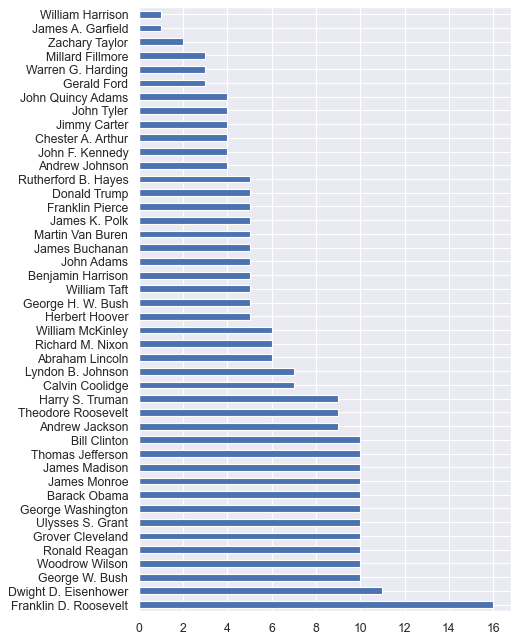

In [706]:
plt.figure(figsize=(6, 10), dpi=80)
major_speeches_df.President.value_counts().plot(kind='barh')
plt.suptitle('Number of Speeches delivered by each President', fontsize=20)
#major_speeches_df['characters'].hist()

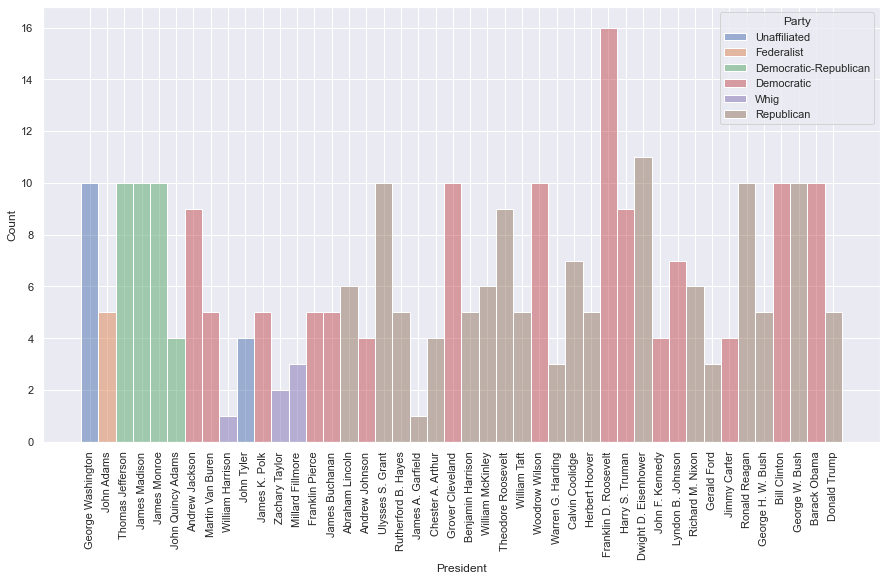

In [574]:
plt.figure(figsize = (15,8))
ax=sns.histplot(data=major_speeches_df, x="President", bins=44, hue="Party")
ax.tick_params(axis='x', rotation=90)
plt.suptitle('Number of Speeches delivered by each President', fontsize=20)

<a name =stepb3></a>
## B3. Written Speeches vs Oral Speeches
Length of speechs by character i.e. letters, spaces and punctuation

[Go to top](#top)

In [495]:
len(major_speeches_df.Transcript.iloc[30])
#Includes letters, spaces and punctuation
#len('Hi how are you? Do you?')

19415

In [496]:
len_char = [len(major_speeches_df.Transcript.iloc[i]) for i in range(major_speeches_df.shape[0])]
major_speeches_df["characters"] = len_char
major_speeches_df.head()

,Date,President,President No.,Party,Speech Title,Speech_Type,Summary,Transcript,URL,characters
0,1789-04-30,George Washington,1,Unaffiliated,First Inaugural Address,oral,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...,8677
1,1790-01-08,George Washington,1,Unaffiliated,First Annual Message to Congress,oral,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,5282
2,1790-12-08,George Washington,1,Unaffiliated,Second Annual Message to Congress,oral,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,8377
3,1791-10-25,George Washington,1,Unaffiliated,Third Annual Message to Congress,oral,Washington praises the success of the new bank...,"I meet you, upon the present occasion, with th...",https://millercenter.org/the-presidency/presid...,13938
4,1792-11-06,George Washington,1,Unaffiliated,Fourth Annual Message to Congress,oral,NaN,"Fellow Citizens of the Senate, and of the Hous...",https://millercenter.org/the-presidency/presid...,14226


### Trend in Written and Oral State of the Union Speeches over time
I labelled the speeches in the dataset as written or oral speeches. Speeches were initially delivered orally by George Washington and John Adams; the first and second presidents. From Thomas Jefferson onward the State of the Union were written addresses to Congress until Wildrow Wilson in 1913 who, and the subsequent 11 presidents, gave a mix of oral and written speeches. Until 1981 when Ronald Reagan came into office and all presidential address became oral once again.

Inaugural addresses throughout the years were all oral. 

### Warren Harding's 1922 speech was the first to be broadcast on radio
"Warren Harding's 1922 speech was the first to be broadcast on radio, albeit to a limited audience, while Calvin Coolidge's 1923 speech was the first to be broadcast across the nation."
Source: https://en.wikipedia.org/wiki/State_of_the_Union#:~:text=Warren%20Harding's%201922%20speech,followed%20again%20until%20the%201960s.

### First Televised Speech 
THe first televised SOTU was by Truman in 1947.

### Length of Written Speeches
The length of Written Speeches was trending upward until 1920 when there was a sharp decline in the the length of written speeches. With the advent of media technologies like the radio and television Presidents had more avenues and more effective avenues to share their agenda. See plot below.

<AxesSubplot:xlabel='Date', ylabel='characters'>

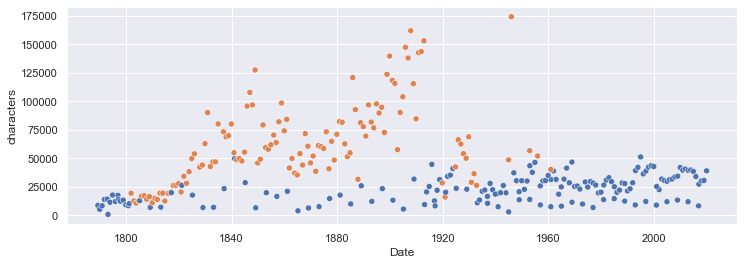

In [499]:
plt.figure(figsize = (15,8))
sns.scatterplot(data=major_speeches_df, x="Date", y="characters", hue="Speech_Type", legend=False)
plt.suptitle('Length of Presidential Speeches over time', fontsize=20)

<a name =stepb4></a>
## B4. Number of Words in Presidential Speeches
Length of speechs by words. Removing punctuation and irrelevant terms where possible as determined in the [Data Cleaning](#stepiv) section below.


[Go to top](#top)

In [585]:
def clean_sent(doc):
    # Tokenize, clean up input document string
    doc = re.sub(r'\[[^()]*\]',"", doc)#removes [Applause]["Laughter"]
    doc = re.sub(r'\([^()]*\)',"", doc)#removes (Applause)("Laughter")
    doc = re.sub(r'[^\w\s]', "", doc)# removes punctuation
    doc = re.sub(r'\b[A-Z][A-Z0-9]+\b',"",doc) #remove ALL CAPS
    doc=" ".join(doc.split()) #remove double whitespace
    return doc.lower()
    #return [token for token in simple_preprocess(doc, min_len=0, max_len=float("inf"))] #used for Gensim model

In [586]:
def clean(doc):
    # Tokenize, clean up input document string
    doc = re.sub(r'\[[^()]*\]',"", doc)#removes [Applause]["Laughter"]
    doc = re.sub(r'\([^()]*\)',"", doc)#removes (Applause)("Laughter")
    doc = re.sub(r'[^\w\s]', "", doc)# removes punctuation
    doc = re.sub(r'\b[A-Z][A-Z0-9]+\b',"",doc) #remove ALL CAPS
    doc=" ".join(doc.split()) #remove double whitespace
    return doc.lower()

In [378]:
#clean("Hi how are Cow ; 'you don't' "" THOMAS JEFF you (laughter) [Applause]? Do you?'=") #len(clean('Hi how are Cow THOMAS JEFF you [Applause]? Do you?'))

In [587]:
# remove empty tokens
speech=(major_speeches_df.Transcript.iloc[30])
words = word_tokenize(speech)
cleaned_token = [clean(token) for token in words]
cleanup_tokens = [tok for tok in cleaned_token if tok]
empty_tokens = [tok for tok in cleaned_token if not tok]

In [487]:
#len(words),len(cleanup_tokens),len(empty_tokens)

(5459, 5071, 388)

### Length by words cont'd

In [588]:
def len_speech(df): 
    length_speech=[] 
    for i in range(df.shape[0]):
        speech=(df.Transcript.iloc[i])
        words = word_tokenize(speech)
        cleaned_token = [clean(token) for token in words]
        cleanup_tokens = [tok for tok in cleaned_token if tok]
        empty_tokens = [tok for tok in cleaned_token if not tok]
        length_speech.append(len(cleanup_tokens))
    return length_speech

In [589]:
length_each_speech = len_speech(major_speeches_df)
#length_each_speech
#len(length_each_speech)

#### Plots for Length Words

In [590]:
major_speeches_df["speech_length"] = length_each_speech
major_speeches_df.head()

,Date,President,President No.,Party,Speech Title,Speech_Type,Summary,Transcript,URL,characters,speech_length
0,1789-04-30,George Washington,1,Unaffiliated,First Inaugural Address,oral,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...,8677,1434
1,1790-01-08,George Washington,1,Unaffiliated,First Annual Message to Congress,oral,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,5282,848
2,1790-12-08,George Washington,1,Unaffiliated,Second Annual Message to Congress,oral,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,8377,1401
3,1791-10-25,George Washington,1,Unaffiliated,Third Annual Message to Congress,oral,Washington praises the success of the new bank...,"I meet you, upon the present occasion, with th...",https://millercenter.org/the-presidency/presid...,13938,2265
4,1792-11-06,George Washington,1,Unaffiliated,Fourth Annual Message to Congress,oral,NaN,"Fellow Citizens of the Senate, and of the Hous...",https://millercenter.org/the-presidency/presid...,14226,2357


#### Comparing length of Written vs Oral speeches

<AxesSubplot:xlabel='speech_length', ylabel='Count'>

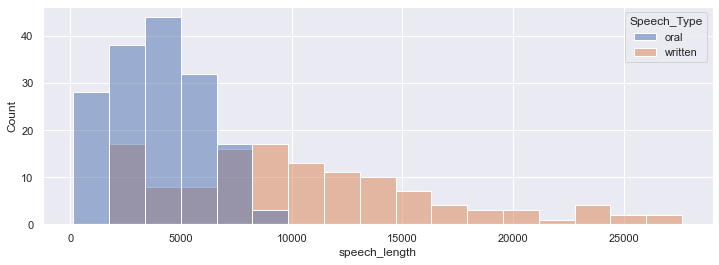

In [596]:
sns.histplot(data=major_speeches_df, x='speech_length', hue="Speech_Type")

In [ ]:
plt.figure(figsize = (15,8))
ax=sns.histplot(data=major_speeches_df, x="President", bins=44, hue="Party")
ax.tick_params(axis='x', rotation=90)

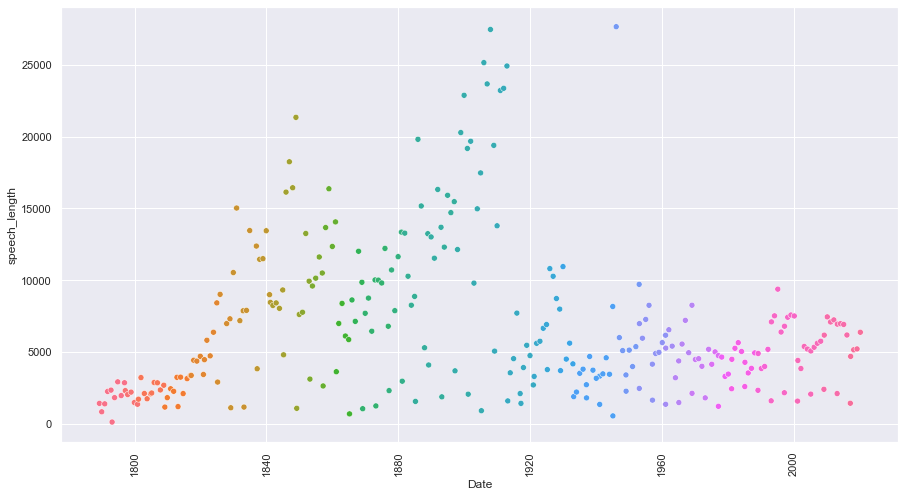

In [600]:
plt.figure(figsize = (15,8))
ax=sns.scatterplot(data=major_speeches_df, x="Date", y="speech_length", hue="President", legend=False)
ax.tick_params(axis='x', rotation=90)
plt.suptitle('Number of words in Presidential Speeches over time', fontsize=20)

### Oral speeches got longer when they stopped relying on written speeches.  See plot below

/var/folders/m6/fxj587w93gn106xqhsxs8g7r0000gn/T/ipykernel_21361/1532196242.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ax=sns.scatterplot(data=major_speeches_df[mask_pre_1922][major_speeches_df.Speech_Type=="written"], x="Date", y="speech_length", hue="President", legend=False)


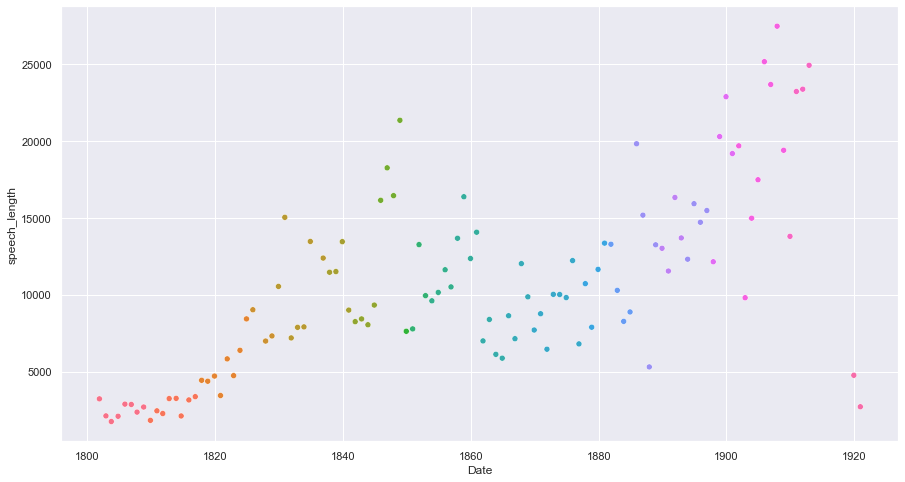

In [602]:
plt.figure(figsize = (15,8))
ax=sns.scatterplot(data=major_speeches_df[mask_pre_1922][major_speeches_df.Speech_Type=="written"], x="Date", y="speech_length", hue="President", legend=False)
plt.suptitle('Number of words in Oral Speeches over time', fontsize=20)


plt.figure(figsize = (15,8))
ax=sns.scatterplot(data=major_speeches_df[mask_post_1922][major_speeches_df.Speech_Type=="oral"], x="Date", y="speech_length", hue="President", legend=False)
ax.tick_params(axis='x', rotation=90)
plt.suptitle('Number of words in Oral Speeches over time', fontsize=20)

<a name =stepb5></a>
## B5. Presidents with the longest and shortest speeches (by number of words)


[Go to top](#top)

### Top 5 longest Written Speeches

In [663]:
major_speeches_df[major_speeches_df["Speech_Type"]=="written"].sort_values(by='speech_length', ascending=False).head(5)


,Date,President,President No.,Party,Speech Title,Speech_Type,Summary,Transcript,URL,characters,speech_length,cleaned_words,Sentences,num_sentences,cleaned_sentences,num_cleaned_sentences,transcripts_new,common_sentences
267,1946-01-21,Harry S. Truman,32,Democratic,First Annual Message,written,Message to the Congress on the State of the Un...,To the Congress of the United States: A quarte...,https://www.presidency.ucsb.edu/documents/mess...,174067,27645,"{'the': 2125, 'of': 1259, 'and': 929, 'to': 73...",[To the Congress of the United States: A quart...,1261,[to the congress of the united states a quarte...,1259,[quarter century ago decided could longer cons...,"{'2': 6, '3': 5, 'i': 4, '4': 4, '1': 2}"
144,1907-12-03,Theodore Roosevelt,31,Republican,Seventh Annual Message,written,NaN,To the Senate and House of Representatives: No...,https://millercenter.org/the-presidency/presid...,161808,27452,"{'the': 2431, 'of': 1418, 'to': 941, 'and': 86...",[To the Senate and House of Representatives: N...,841,[to the senate and house of representatives no...,841,[senate house representative greater resource ...,{'to the senate and house of representatives n...
142,1905-12-05,Theodore Roosevelt,31,Republican,Fifth Annual Message,written,NaN,To the Senate and House of Representatives: Th...,https://millercenter.org/the-presidency/presid...,147314,25146,"{'the': 2126, 'of': 1307, 'to': 912, 'and': 72...",[To the Senate and House of Representatives: T...,789,[to the senate and house of representatives th...,789,[senate house representative continue enjoy pr...,{'to the senate and house of representatives t...
150,1912-12-03,William Taft,26,Republican,Fourth Annual Message,written,NaN,Part 1. [ On Our Foreign Relations. ] To the S...,https://millercenter.org/the-presidency/presid...,152985,24909,"{'the': 2499, 'of': 1569, 'to': 804, 'and': 78...","[Part 1., [ On Our Foreign Relations. ], To th...",736,"[part 1, to the senate and house of representa...",732,"[part 1, senate house representative foreign r...","{'part': 2, 'h': 2, 'part 1': 1, 'to the senat..."
143,1906-12-03,Theodore Roosevelt,31,Republican,Sixth Annual Message,written,NaN,To the Senate and House of Representatives: As...,https://millercenter.org/the-presidency/presid...,137929,23662,"{'the': 2009, 'of': 1218, 'to': 821, 'and': 77...",[To the Senate and House of Representatives: A...,651,[to the senate and house of representatives as...,651,[senate house representative still continue en...,{'to the senate and house of representatives a...


### Top 5 shortest Written Speeches

In [664]:
major_speeches_df[major_speeches_df["Speech_Type"]=="written"].sort_values(by='speech_length', ascending=False).tail(5)


,Date,President,President No.,Party,Speech Title,Speech_Type,Summary,Transcript,URL,characters,speech_length,cleaned_words,Sentences,num_sentences,cleaned_sentences,num_cleaned_sentences,transcripts_new,common_sentences
17,1802-12-15,Thomas Jefferson,3,Democratic-Republican,Second Annual Message,written,President Jefferson discusses Indian relations...,To the Senate and House of Representatives of ...,https://millercenter.org/the-presidency/presid...,12533,2121,"{'the': 160, 'of': 121, 'and': 78, 'to': 65, '...",[To the Senate and House of Representatives of...,59,[to the senate and house of representatives of...,59,[senate house representative assemble together...,{'to the senate and house of representatives o...
31,1814-09-20,James Madison,4,Democratic-Republican,Sixth Annual Message,written,"In an upbeat message to Congress, Madison focu...",Fellow Citizens of the Senate & of the House o...,https://millercenter.org/the-presidency/presid...,12546,2116,"{'the': 193, 'of': 125, 'and': 86, 'to': 48, '...",[Fellow Citizens of the Senate & of the House ...,50,[fellow citizens of the senate of the house of...,50,[fellow senate house representative notwithsta...,{'fellow citizens of the senate of the house o...
19,1804-11-08,Thomas Jefferson,3,Democratic-Republican,Fourth Annual Message,written,Jefferson focuses primarily on relations with ...,To the Senate and House of Representatives of ...,https://millercenter.org/the-presidency/presid...,12546,2098,"{'the': 180, 'of': 140, 'and': 70, 'to': 66, '...",[To the Senate and House of Representatives of...,51,[to the senate and house of representatives of...,51,[senate house representative fellow sincerely ...,{'to the senate and house of representatives o...
25,1809-11-29,James Madison,4,Democratic-Republican,First Annual Message,written,Madison outlines the difficulties in the relat...,Fellow Citizens of the Senate and of the House...,https://millercenter.org/the-presidency/presid...,10989,1832,"{'the': 173, 'of': 106, 'to': 65, 'and': 51, '...",[Fellow Citizens of the Senate and of the Hous...,40,[fellow citizens of the senate and of the hous...,40,[fellow senate house representative period mee...,{'fellow citizens of the senate and of the hou...
18,1803-10-17,Thomas Jefferson,3,Democratic-Republican,Third Annual Message,written,Jefferson discusses the implications of the Lo...,: for confirming to the Indian inhabitants the...,https://millercenter.org/the-presidency/presid...,10706,1755,"{'the': 131, 'of': 104, 'and': 75, 'to': 56, '...",[: for confirming to the Indian inhabitants th...,37,[for confirming to the indian inhabitants thei...,37,[confirming indian inhabitant occupancy self e...,{'for confirming to the indian inhabitants the...


### Top 5 longest Oral Speeches

In [665]:
major_speeches_df[major_speeches_df["Speech_Type"]=="oral"].sort_values(by='speech_length', ascending=False).head(5)


,Date,President,President No.,Party,Speech Title,Speech_Type,Summary,Transcript,URL,characters,speech_length,cleaned_words,Sentences,num_sentences,cleaned_sentences,num_cleaned_sentences,transcripts_new,common_sentences
227,1995-01-24,Bill Clinton,41,Democratic,State of the Union Address,oral,"Clinton speaks of establishing a New Covenant,...","Mr. President, Mr. Speaker, members of the 104...",https://millercenter.org/the-presidency/presid...,51193,9382,"{'the': 463, 'to': 402, 'and': 352, 'of': 231,...","[Mr. President, Mr. Speaker, members of the 10...",452,[mr president mr speaker members of the 104th ...,452,[mr president mr speaker member 104th fellow a...,{'mr president mr speaker members of the 104th...
62,1841-03-04,William Harrison,9,Whig,Inaugural Address,oral,President Harrison begins by describing how Am...,Called from a retirement which I had supposed ...,https://millercenter.org/the-presidency/presid...,49668,8461,"{'the': 829, 'of': 604, 'to': 318, 'and': 231,...",[Called from a retirement which I had supposed...,206,[called from a retirement which i had supposed...,206,[called retirement supposed continue residue l...,{'called from a retirement which i had suppose...
195,1969-01-14,Lyndon B. Johnson,35,Democratic,State of the Union Address,oral,NaN,"Mr. Speaker, Mr. President, Members of the Con...",https://millercenter.org/the-presidency/presid...,46683,8264,"{'the': 588, 'of': 296, 'to': 252, 'that': 224...","[Mr. Speaker, Mr. President, Members of the Co...",374,[mr speaker mr president members of the congre...,374,[mr speaker mr president member fellow america...,{'mr speaker mr president members of the congr...
154,1915-12-07,Woodrow Wilson,27,Democratic,Third Annual Message,oral,NaN,Since I last had the privilege of addressing y...,https://millercenter.org/the-presidency/presid...,44696,7716,"{'the': 523, 'of': 439, 'and': 309, 'to': 265,...",[Since I last had the privilege of addressing ...,223,[since i last had the privilege of addressing ...,223,[since privilege addressing union nation side ...,{'since i last had the privilege of addressing...
232,1999-01-19,Bill Clinton,41,Democratic,State of the Union Address,oral,"In his sixth State of the Union address, Presi...","Mr. Speaker, Mr. Vice President, members of Co...",https://millercenter.org/the-presidency/presid...,43470,7583,"{'the': 355, 'to': 348, 'and': 240, 'of': 176,...","[Mr. Speaker, Mr. Vice President, members of C...",386,[mr speaker mr vice president members of congr...,386,[mr speaker mr vice president member honored g...,"{'thank you': 4, 'i hope you will support it':..."


### Top 5 shortest Oral Speeches

In [666]:
major_speeches_df[major_speeches_df["Speech_Type"]=="oral"].sort_values(by='speech_length', ascending=False).tail(5)


,Date,President,President No.,Party,Speech Title,Speech_Type,Summary,Transcript,URL,characters,speech_length,cleaned_words,Sentences,num_sentences,cleaned_sentences,num_cleaned_sentences,transcripts_new,common_sentences
141,1905-03-04,Theodore Roosevelt,31,Republican,Inaugural Address,oral,NaN,"My fellow citizens, no people on earth have mo...",https://millercenter.org/the-presidency/presid...,5497,923,"{'the': 56, 'of': 40, 'and': 34, 'we': 30, 'to...","[My fellow citizens, no people on earth have m...",33,[my fellow citizens no people on earth have mo...,33,[fellow earth cause thankfulthan ours said rev...,{'my fellow citizens no people on earth have m...
1,1790-01-08,George Washington,1,Unaffiliated,First Annual Message to Congress,oral,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,5282,848,"{'the': 76, 'of': 53, 'to': 42, 'and': 31, 'be...",[Fellow Citizens of the Senate and House of Re...,21,[fellow citizens of the senate and house of re...,21,[fellow senate house representative embrace sa...,{'fellow citizens of the senate and house of r...
92,1865-03-04,Abraham Lincoln,16,Republican,Second Inaugural Address,oral,"Just over a month before his assassination, Li...",Fellow Countrymen: At this second appearing to...,https://millercenter.org/the-presidency/presid...,3923,703,"{'the': 58, 'to': 27, 'and': 24, 'of': 22, 'it...",[Fellow Countrymen: At this second appearing t...,25,[fellow countrymen at this second appearing to...,25,[fellow countryman second appearing take oath ...,{'fellow countrymen at this second appearing t...
182,1945-01-20,Franklin D. Roosevelt,25,Democratic,Fourth Inaugural Address,oral,Franklin Delano Roosevelt makes a brief addres...,"Mr. Chief Justice, Mr. Vice President, my frie...",https://millercenter.org/the-presidency/presid...,2998,562,"{'the': 27, 'of': 26, 'we': 26, 'and': 23, 'to...","[Mr. Chief Justice, Mr. Vice President, my fri...",24,[mr chief justice mr vice president my friends...,24,[mr chief justice mr vice president friend und...,{'mr chief justice mr vice president my friend...
5,1793-03-04,George Washington,1,Unaffiliated,Second Inaugural Address,oral,"In a simple, brief speech, Washington expresse...",Fellow Citizens: I am again called upon by the...,https://millercenter.org/the-presidency/presid...,791,136,"{'the': 13, 'of': 11, 'i': 6, 'to': 5, 'shall'...",[Fellow Citizens: I am again called upon by th...,4,[fellow citizens i am again called upon by the...,4,[fellow am again called voice execute function...,{'fellow citizens i am again called upon by th...


## Talk is cheap!
The top 5 shortest orators in the list. above corresponds to the Top 6 most liked presidents of all time according to https://today.yougov.com/ratings/politics/popularity/US-presidents/all

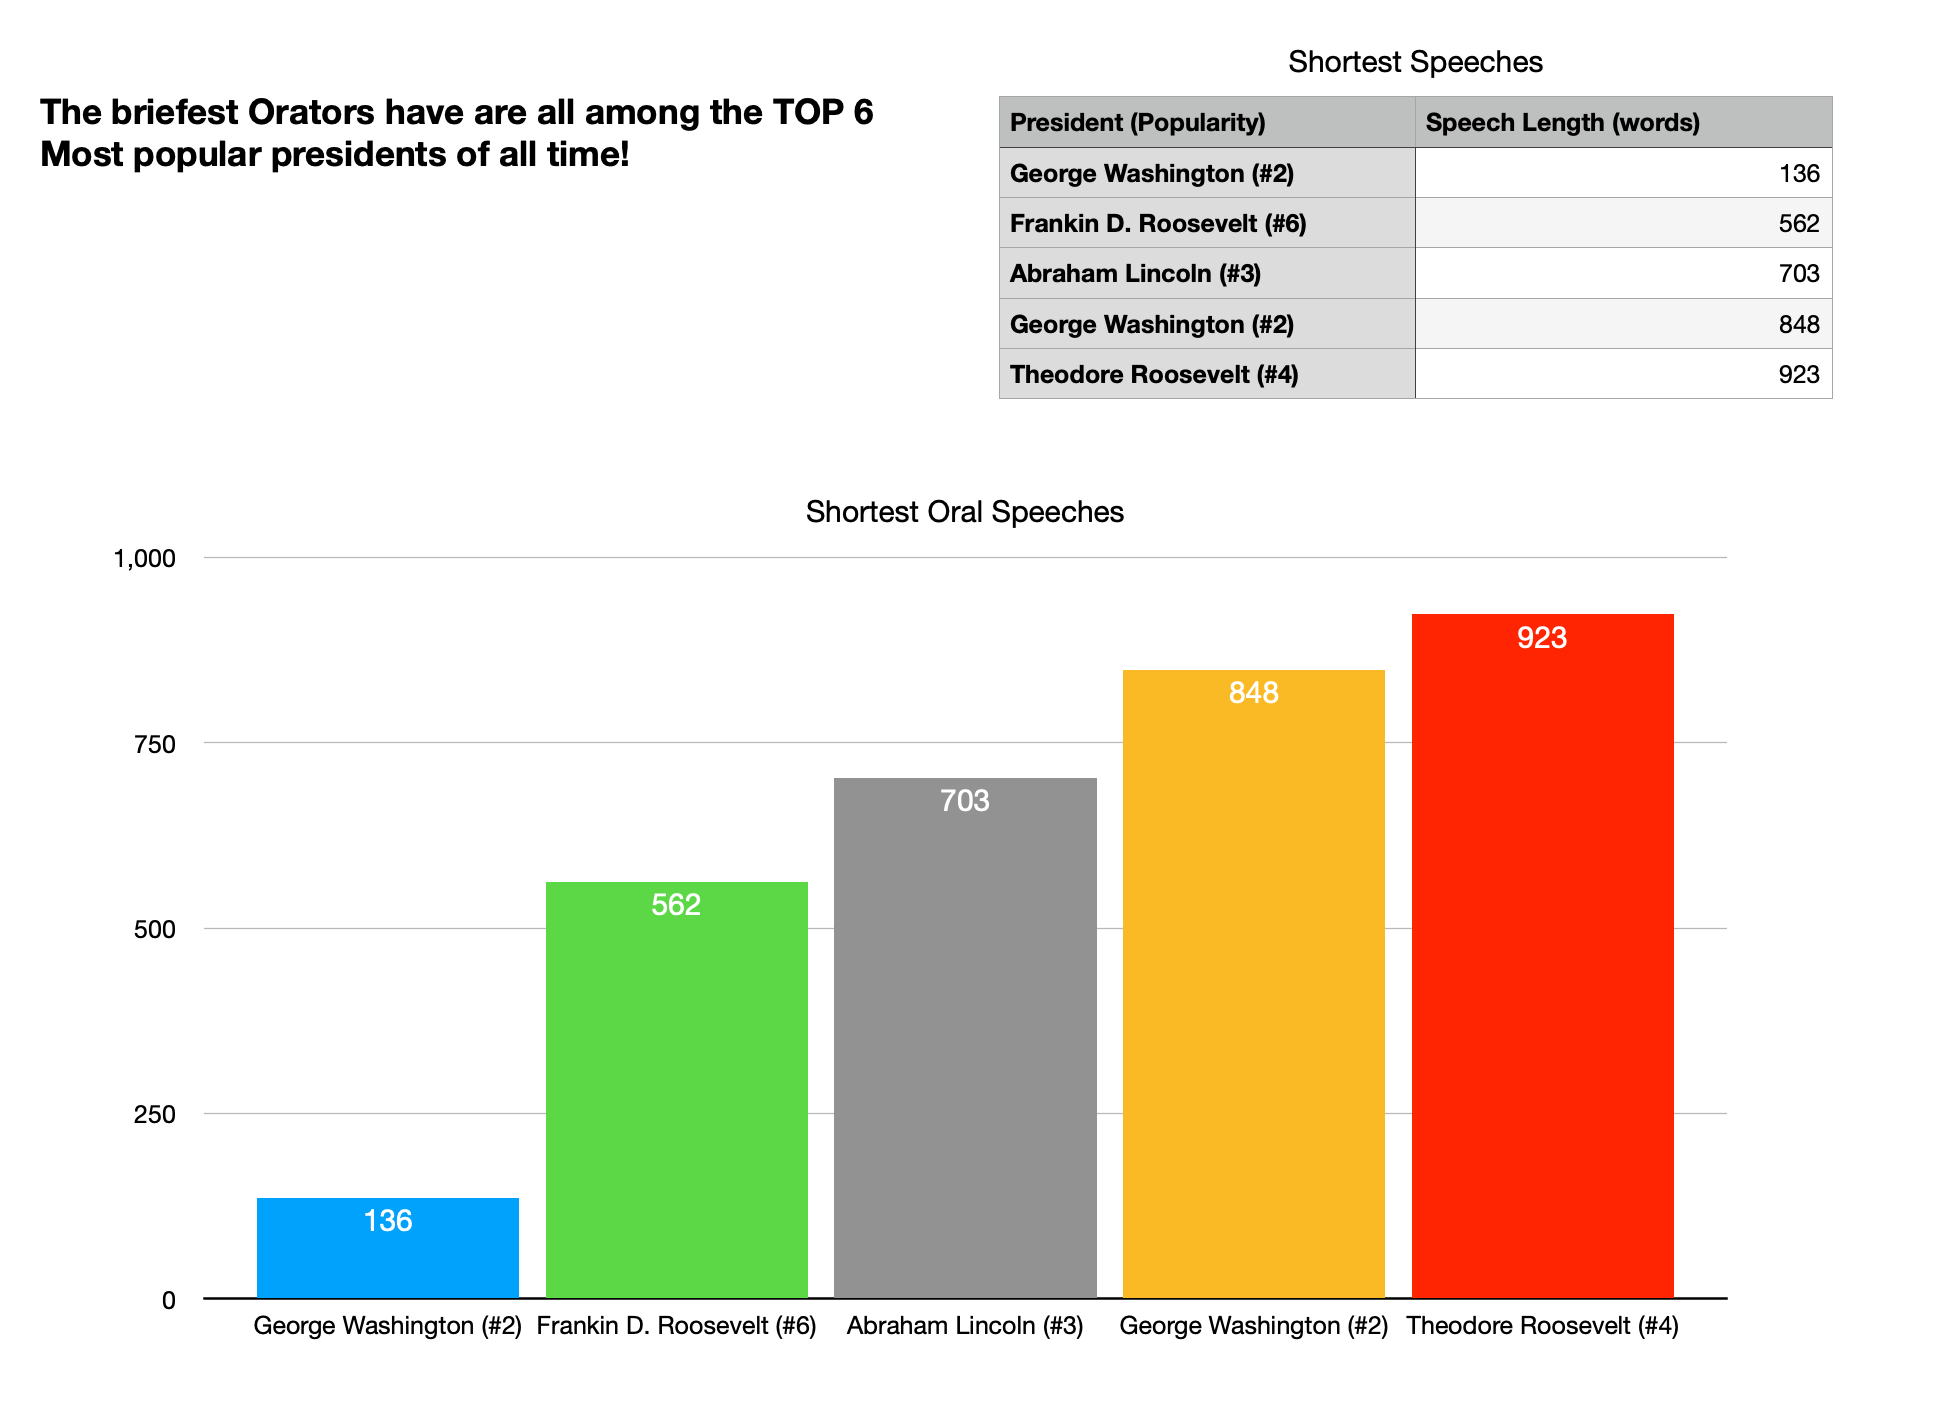

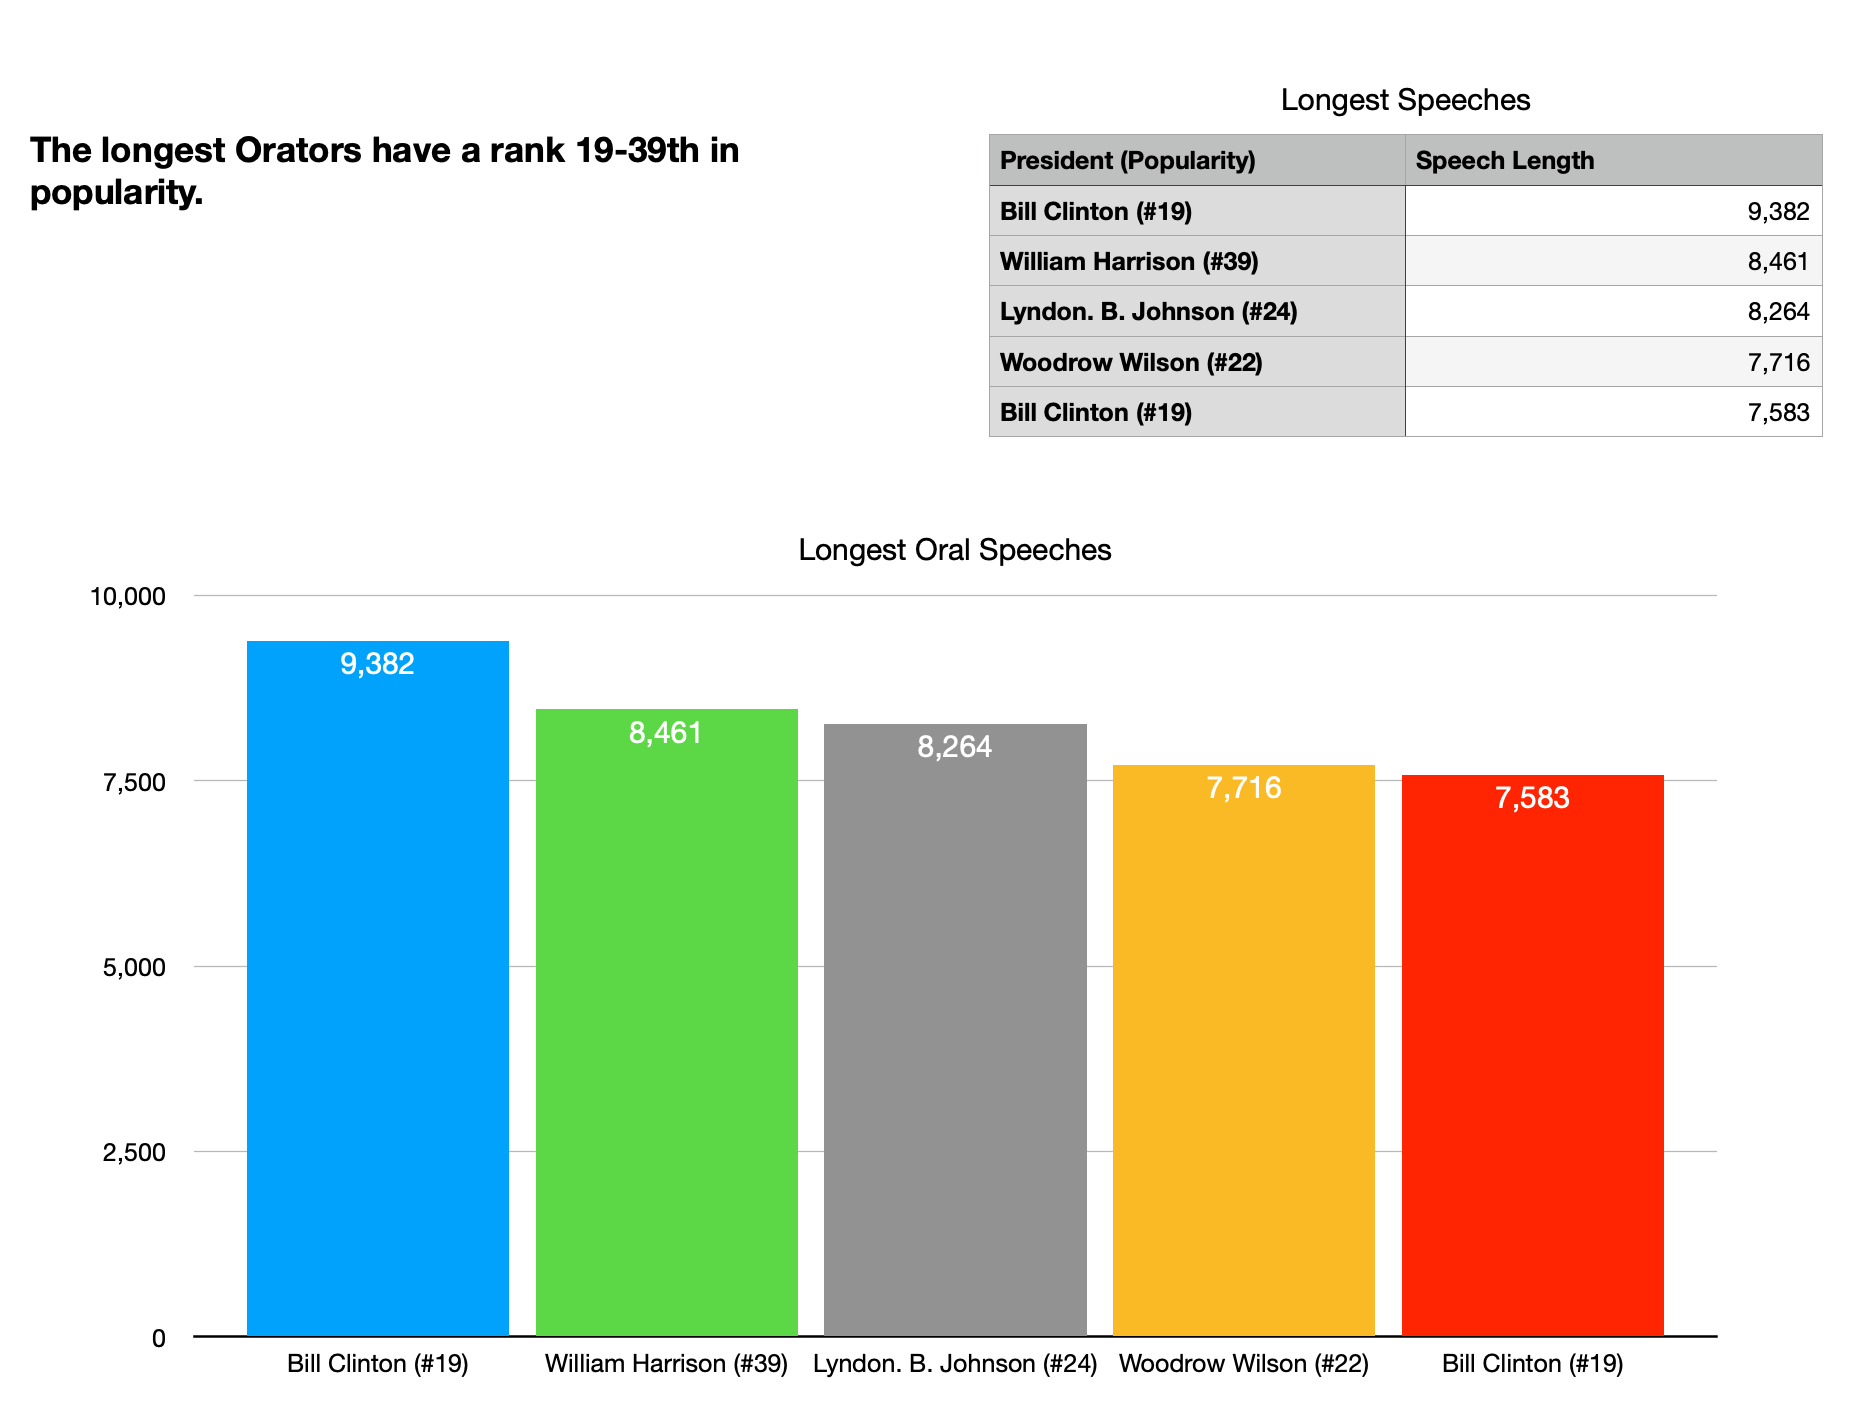

### Overall trend

Text(0.5, 0.98, 'Number of words used in Written Speeches')

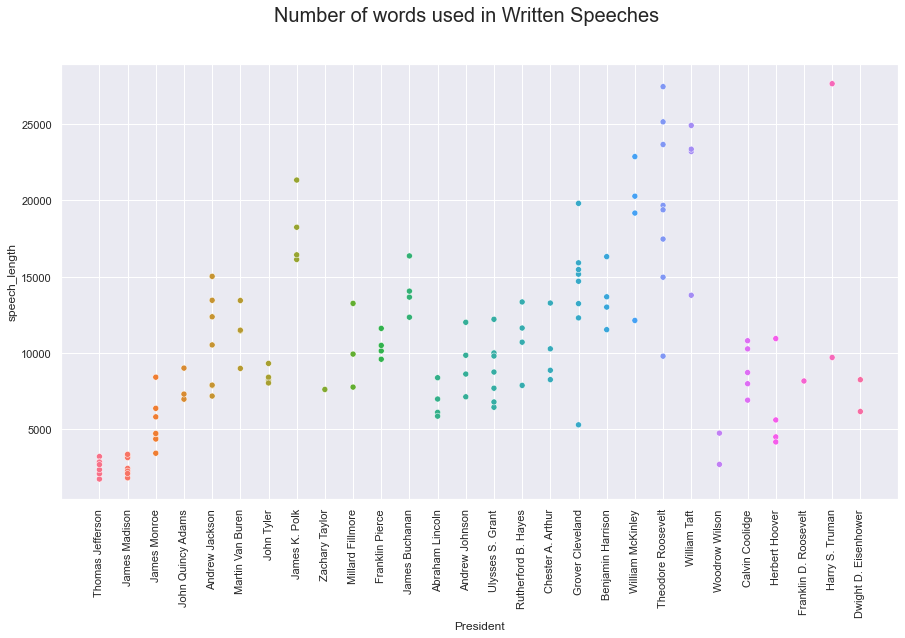

In [659]:
plt.figure(figsize = (15,8))
ax=sns.scatterplot(data=major_speeches_df[major_speeches_df["Speech_Type"]=="written"], x="President", y="speech_length", hue="President", legend=False)
ax.tick_params(axis='x', rotation=90)
plt.suptitle('Number of words used in Written Speeches', fontsize=20)

Text(0.5, 0.98, 'Number of words used in Oral Speeches')

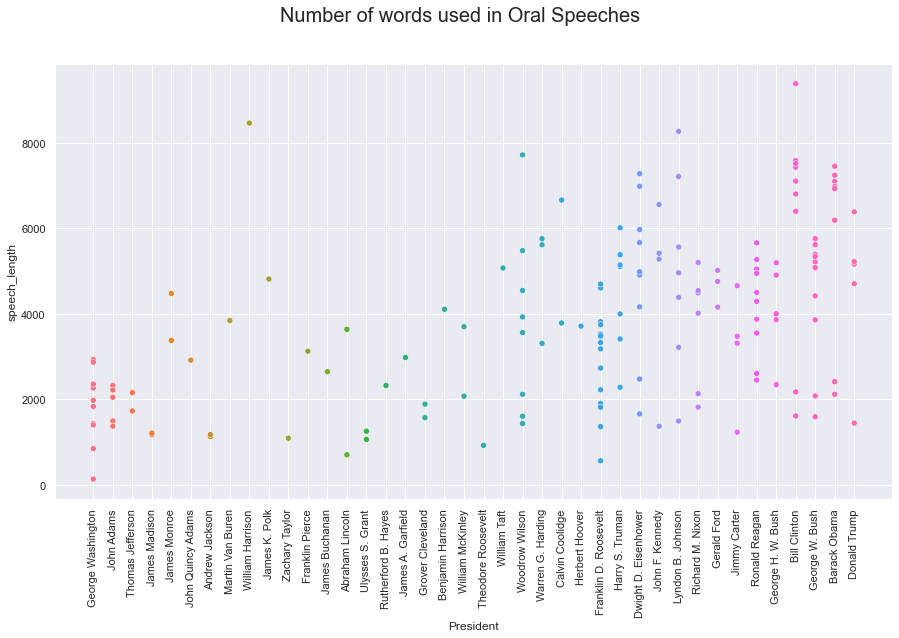

In [662]:
plt.figure(figsize = (15,8))
ax=sns.scatterplot(data=major_speeches_df[major_speeches_df["Speech_Type"]=="oral"], x="President", y="speech_length", hue="President", legend=False)
ax.tick_params(axis='x', rotation=90)
plt.suptitle('Number of words used in Oral Speeches', fontsize=20)

<a name =stepb6></a>
## B6. Number of Sentences


[Go to top](#top)


<a name="normalize"></a>
#### 1. Normalize text
Start with a subset again
Removing punctuation and irrelevant terms where possible as determined in the [Data Cleaning](#stepiv) section below.

In [ ]:
#Decided not to use this built-in preprocessing.
#gensim simple_preprocess - This lowercases, tokenizes, removes punctuation, de-accents (optional). 
#from gensim.utils import simple_preprocess

In [617]:
#normalize senttences
def clean_sent(doc):
    # Tokenize, clean up input document string
    doc = re.sub(r'\[[^()]*\]',"", doc)#removes [Applause]["Laughter"]
    doc = re.sub(r'\([^()]*\)',"", doc)#removes (Applause)("Laughter")
    doc = re.sub(r'[^\w\s]', "", doc)# removes punctuation
    doc = re.sub(r'\b[A-Z][A-Z0-9]+\b',"",doc) #remove ALL CAPS
    doc=" ".join(doc.split()) #remove double whitespace
    return doc.lower()
    #return [token for token in simple_preprocess(doc, min_len=0, max_len=float("inf"))] #used for Gensim model

#remove stop words
stopwords = stops_used(1110)

def remove_stop_words(doc):
    removed_stop_words = []
    for tok_sent in doc:
        removed_stop_words.append(
            ' '.join([word for word in tok_sent.split() 
                      if word not in stopwords])
        )
    return removed_stop_words

#stemming
def get_stemmed_text(doc):
    from nltk.stem.porter import PorterStemmer
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in tok_sent.split()]) for tok_sent in doc]


#lemmatized words
def get_lemmatized_text(doc):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in tok_sent.split()]) for tok_sent in doc]


### Applied lemmatization. Not sure if should have used stemming in this case.

In [618]:
sentences_list=[]
num_sentences=[]
cleanup_sentences_list=[]
num_cleanup_sentences=[]
transcripts_new=[]
for i in range(major_speeches_df.shape[0]): #corpus_df.shape[0]
    speech=(major_speeches_df.Transcript.iloc[i])
    sentences=sent_tokenize(speech)
    sentences_list.append(sentences)
    num_sentences.append(len(sentences))
    cleaned_speeches = [clean_sent(sentence) for sentence in sentences]
    cleanup_sentences = [sent for sent in cleaned_speeches if sent] #remove empty sentences
    cleanup_sentences_list.append(cleanup_sentences)
    num_cleanup_sentences.append(len(cleanup_sentences))
    no_stop_words=remove_stop_words(cleanup_sentences)
    lemmatized_speech = get_lemmatized_text(no_stop_words)
    transcripts_new.append(lemmatized_speech)
sentences_list, num_sentences, cleanup_sentences, num_cleanup_sentences,transcripts_new

major_speeches_df["Sentences"]=sentences_list
major_speeches_df["num_sentences"]=num_sentences
major_speeches_df["cleaned_sentences"]=cleanup_sentences_list
major_speeches_df["num_cleaned_sentences"]=num_cleanup_sentences
major_speeches_df["transcripts_new"]=transcripts_new

In [619]:
major_speeches_df

,Date,President,President No.,Party,Speech Title,Speech_Type,Summary,Transcript,URL,characters,speech_length,cleaned_words,Sentences,num_sentences,cleaned_sentences,num_cleaned_sentences,transcripts_new
0,1789-04-30,George Washington,1,Unaffiliated,First Inaugural Address,oral,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...,8677,1434,"{'the': 117, 'of': 70, 'and': 48, 'to': 48, 'w...",[Fellow Citizens of the Senate and the House o...,24,[fellow citizens of the senate and the house o...,24,[fellow senate house representative among vici...
1,1790-01-08,George Washington,1,Unaffiliated,First Annual Message to Congress,oral,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,5282,848,"{'the': 76, 'of': 53, 'to': 42, 'and': 31, 'be...",[Fellow Citizens of the Senate and House of Re...,21,[fellow citizens of the senate and house of re...,21,[fellow senate house representative embrace sa...
2,1790-12-08,George Washington,1,Unaffiliated,Second Annual Message to Congress,oral,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,8377,1401,"{'the': 120, 'of': 90, 'to': 49, 'and': 44, 'i...",[Fellow citizens of the Senate and House of Re...,40,[fellow citizens of the senate and house of re...,40,[fellow senate house representative meeting ag...
3,1791-10-25,George Washington,1,Unaffiliated,Third Annual Message to Congress,oral,Washington praises the success of the new bank...,"I meet you, upon the present occasion, with th...",https://millercenter.org/the-presidency/presid...,13938,2265,"{'the': 237, 'of': 156, 'to': 88, 'and': 73, '...","[I meet you, upon the present occasion, with t...",58,[i meet you upon the present occasion with the...,58,[meet occasion feeling naturally inspired stro...
4,1792-11-06,George Washington,1,Unaffiliated,Fourth Annual Message to Congress,oral,NaN,"Fellow Citizens of the Senate, and of the Hous...",https://millercenter.org/the-presidency/presid...,14226,2357,"{'the': 215, 'of': 153, 'to': 101, 'and': 61, ...","[Fellow Citizens of the Senate, and of the Hou...",64,[fellow citizens of the senate and of the hous...,64,[fellow senate house representative abatement ...
5,1793-03-04,George Washington,1,Unaffiliated,Second Inaugural Address,oral,"In a simple, brief speech, Washington expresse...",Fellow Citizens: I am again called upon by the...,https://millercenter.org/the-presidency/presid...,791,136,"{'the': 13, 'of': 11, 'i': 6, 'to': 5, 'shall'...",[Fellow Citizens: I am again called upon by th...,4,[fellow citizens i am again called upon by the...,4,[fellow am again called voice execute function...
6,1793-12-03,George Washington,1,Unaffiliated,Fifth Annual Message to Congress,oral,Devoting much of his message to foreign affair...,Fellow Citizens of the Senate and of the House...,https://millercenter.org/the-presidency/presid...,11464,1834,"{'the': 162, 'of': 122, 'to': 64, 'and': 42, '...",[Fellow Citizens of the Senate and of the Hous...,55,[fellow citizens of the senate and of the hous...,55,"[fellow senate house representative, since com..."
7,1794-11-19,George Washington,1,Unaffiliated,Sixth Annual Message to Congress,oral,The President outlines his response to the Whi...,Fellow Citizens of the Senate and of the House...,https://millercenter.org/the-presidency/presid...,17773,2932,"{'the': 275, 'of': 188, 'to': 138, 'and': 87, ...",[Fellow Citizens of the Senate and of the Hous...,77,[fellow citizens of the senate and of the hous...,77,[fellow senate house representative call mind ...
8,1795-12-08,George Washington,1,Unaffiliated,Seventh Annual Message to Congress,oral,Washington's 1795 speech is imbued with a sens...,I trust I do not deceive myself when I indulge...,https://millercenter.org/the-presidency/pre

<AxesSubplot:>

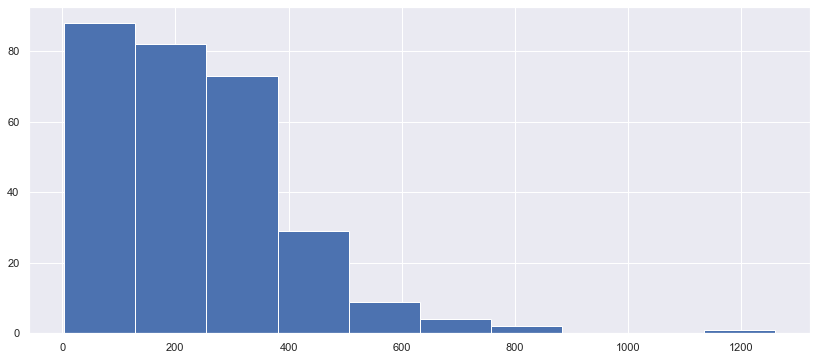

In [621]:
major_speeches_df['num_cleaned_sentences'].hist()

# Presidents with most and least number of sentences

## Written

In [681]:
major_speeches_df[major_speeches_df["Speech_Type"]=="written"].sort_values(by='num_cleaned_sentences', ascending=False).head(5)


,Date,President,President No.,Party,Speech Title,Speech_Type,Summary,Transcript,URL,characters,speech_length,cleaned_words,Sentences,num_sentences,cleaned_sentences,num_cleaned_sentences,transcripts_new,common_sentences
267,1946-01-21,Harry S. Truman,32,Democratic,First Annual Message,written,Message to the Congress on the State of the Un...,To the Congress of the United States: A quarte...,https://www.presidency.ucsb.edu/documents/mess...,174067,27645,"{'the': 2125, 'of': 1259, 'and': 929, 'to': 73...",[To the Congress of the United States: A quart...,1261,[to the congress of the united states a quarte...,1259,[quarter century ago decided could longer cons...,"{'2': 6, '3': 5, 'i': 4, '4': 4, '1': 2}"
144,1907-12-03,Theodore Roosevelt,31,Republican,Seventh Annual Message,written,NaN,To the Senate and House of Representatives: No...,https://millercenter.org/the-presidency/presid...,161808,27452,"{'the': 2431, 'of': 1418, 'to': 941, 'and': 86...",[To the Senate and House of Representatives: N...,841,[to the senate and house of representatives no...,841,[senate house representative greater resource ...,{'to the senate and house of representatives n...
142,1905-12-05,Theodore Roosevelt,31,Republican,Fifth Annual Message,written,NaN,To the Senate and House of Representatives: Th...,https://millercenter.org/the-presidency/presid...,147314,25146,"{'the': 2126, 'of': 1307, 'to': 912, 'and': 72...",[To the Senate and House of Representatives: T...,789,[to the senate and house of representatives th...,789,[senate house representative continue enjoy pr...,{'to the senate and house of representatives t...
150,1912-12-03,William Taft,26,Republican,Fourth Annual Message,written,NaN,Part 1. [ On Our Foreign Relations. ] To the S...,https://millercenter.org/the-presidency/presid...,152985,24909,"{'the': 2499, 'of': 1569, 'to': 804, 'and': 78...","[Part 1., [ On Our Foreign Relations. ], To th...",736,"[part 1, to the senate and house of representa...",732,"[part 1, senate house representative foreign r...","{'part': 2, 'h': 2, 'part 1': 1, 'to the senat..."
134,1899-12-05,William McKinley,24,Republican,Third Annual Message,written,NaN,To the Senate and House of Representatives: At...,https://millercenter.org/the-presidency/presid...,139601,22870,"{'the': 2340, 'of': 1495, 'and': 841, 'to': 71...",[To the Senate and House of Representatives: A...,701,[to the senate and house of representatives at...,701,[senate house representative threshold your de...,{'to the senate and house of representatives a...


In [680]:
major_speeches_df[major_speeches_df["Speech_Type"]=="written"].sort_values(by='num_cleaned_sentences', ascending=False).tail(5)


,Date,President,President No.,Party,Speech Title,Speech_Type,Summary,Transcript,URL,characters,speech_length,cleaned_words,Sentences,num_sentences,cleaned_sentences,num_cleaned_sentences,transcripts_new,common_sentences
19,1804-11-08,Thomas Jefferson,3,Democratic-Republican,Fourth Annual Message,written,Jefferson focuses primarily on relations with ...,To the Senate and House of Representatives of ...,https://millercenter.org/the-presidency/presid...,12546,2098,"{'the': 180, 'of': 140, 'and': 70, 'to': 66, '...",[To the Senate and House of Representatives of...,51,[to the senate and house of representatives of...,51,[senate house representative fellow sincerely ...,{'to the senate and house of representatives o...
31,1814-09-20,James Madison,4,Democratic-Republican,Sixth Annual Message,written,"In an upbeat message to Congress, Madison focu...",Fellow Citizens of the Senate & of the House o...,https://millercenter.org/the-presidency/presid...,12546,2116,"{'the': 193, 'of': 125, 'and': 86, 'to': 48, '...",[Fellow Citizens of the Senate & of the House ...,50,[fellow citizens of the senate of the house of...,50,[fellow senate house representative notwithsta...,{'fellow citizens of the senate of the house o...
27,1811-11-05,James Madison,4,Democratic-Republican,Third Annual Message,written,Responding the crisis with the European powers...,Fellow Citizens of the Senate and of the House...,https://millercenter.org/the-presidency/presid...,13856,2275,"{'the': 205, 'of': 136, 'to': 88, 'and': 73, '...",[Fellow Citizens of the Senate and of the Hous...,46,[fellow citizens of the senate and of the hous...,46,[fellow senate house representative calling to...,{'fellow citizens of the senate and of the hou...
25,1809-11-29,James Madison,4,Democratic-Republican,First Annual Message,written,Madison outlines the difficulties in the relat...,Fellow Citizens of the Senate and of the House...,https://millercenter.org/the-presidency/presid...,10989,1832,"{'the': 173, 'of': 106, 'to': 65, 'and': 51, '...",[Fellow Citizens of the Senate and of the Hous...,40,[fellow citizens of the senate and of the hous...,40,[fellow senate house representative period mee...,{'fellow citizens of the senate and of the hou...
18,1803-10-17,Thomas Jefferson,3,Democratic-Republican,Third Annual Message,written,Jefferson discusses the implications of the Lo...,: for confirming to the Indian inhabitants the...,https://millercenter.org/the-presidency/presid...,10706,1755,"{'the': 131, 'of': 104, 'and': 75, 'to': 56, '...",[: for confirming to the Indian inhabitants th...,37,[for confirming to the indian inhabitants thei...,37,[confirming indian inhabitant occupancy self e...,{'for confirming to the indian inhabitants the...


## Oral

In [679]:
major_speeches_df[major_speeches_df["Speech_Type"]=="oral"].sort_values(by='num_cleaned_sentences', ascending=False).head(5)

,Date,President,President No.,Party,Speech Title,Speech_Type,Summary,Transcript,URL,characters,speech_length,cleaned_words,Sentences,num_sentences,cleaned_sentences,num_cleaned_sentences,transcripts_new,common_sentences
227,1995-01-24,Bill Clinton,41,Democratic,State of the Union Address,oral,"Clinton speaks of establishing a New Covenant,...","Mr. President, Mr. Speaker, members of the 104...",https://millercenter.org/the-presidency/presid...,51193,9382,"{'the': 463, 'to': 402, 'and': 352, 'of': 231,...","[Mr. President, Mr. Speaker, members of the 10...",452,[mr president mr speaker members of the 104th ...,452,[mr president mr speaker member 104th fellow a...,{'mr president mr speaker members of the 104th...
247,2012-01-24,Barack Obama,43,Democratic,2012 State of the Union Address,oral,President Obama delivers the 2012 State of the...,"Mr. Speaker, Mr. Vice President, members of Co...",https://millercenter.org/the-presidency/presid...,40595,7242,"{'the': 295, 'to': 230, 'and': 205, 'of': 170,...","[Mr. Speaker, Mr. Vice President, members of C...",422,[mr speaker mr vice president members of congr...,421,[mr speaker mr vice president member distingui...,{'mr speaker mr vice president members of cong...
245,2010-01-27,Barack Obama,43,Democratic,2010 State of the Union Address,oral,"In his first State of the Union address, Presi...","Madam Speaker, Vice President Biden, Members o...",https://millercenter.org/the-presidency/presid...,41916,7453,"{'the': 337, 'to': 239, 'and': 235, 'that': 17...","[Madam Speaker, Vice President Biden, Members ...",421,[madam speaker vice president biden members of...,421,[madam speaker vice president biden member dis...,"{'not now': 2, 'let me know': 2, 'lets get it ..."
246,2011-01-25,Barack Obama,43,Democratic,2011 State of the Union Address,oral,The president delivers his State of the Union ...,"Mr. Speaker, Mr. Vice President, members of Co...",https://millercenter.org/the-presidency/presid...,39599,7097,"{'the': 355, 'and': 246, 'to': 219, 'of': 195,...","[Mr. Speaker, Mr. Vice President, members of C...",408,[mr speaker mr vice president members of congr...,401,[mr speaker mr vice president member distingui...,{'mr speaker mr vice president members of cong...
226,1994-01-25,Bill Clinton,41,Democratic,State of the Union Address,oral,President Clinton applauds the successes in br...,"Thank you very much. Mr. Speaker, Mr. Presiden...",https://millercenter.org/the-presidency/presid...,42071,7525,"{'the': 325, 'to': 301, 'and': 247, 'we': 168,...","[Thank you very much., Mr. Speaker, Mr. Presid...",394,"[thank you very much, mr speaker mr president ...",394,"[thank very much, mr speaker mr president memb...","{'thank you very much': 1, 'mr speaker mr pres..."


In [678]:
major_speeches_df[major_speeches_df["Speech_Type"]=="oral"].sort_values(by='num_cleaned_sentences', ascending=False).tail(5)

,Date,President,President No.,Party,Speech Title,Speech_Type,Summary,Transcript,URL,characters,speech_length,cleaned_words,Sentences,num_sentences,cleaned_sentences,num_cleaned_sentences,transcripts_new,common_sentences
0,1789-04-30,George Washington,1,Unaffiliated,First Inaugural Address,oral,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...,8677,1434,"{'the': 117, 'of': 70, 'and': 48, 'to': 48, 'w...",[Fellow Citizens of the Senate and the House o...,24,[fellow citizens of the senate and the house o...,24,[fellow senate house representative among vici...,{'fellow citizens of the senate and the house ...
24,1809-03-04,James Madison,4,Democratic-Republican,First Inaugural Address,oral,Madison begins his address by acknowledging th...,Unwilling to depart from examples of the most ...,https://millercenter.org/the-presidency/presid...,6988,1177,"{'the': 104, 'of': 69, 'to': 61, 'and': 43, 'i...",[Unwilling to depart from examples of the most...,21,[unwilling to depart from examples of the most...,21,[unwilling depart example revered authority av...,{'unwilling to depart from examples of the mos...
1,1790-01-08,George Washington,1,Unaffiliated,First Annual Message to Congress,oral,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,5282,848,"{'the': 76, 'of': 53, 'to': 42, 'and': 31, 'be...",[Fellow Citizens of the Senate and House of Re...,21,[fellow citizens of the senate and house of re...,21,[fellow senate house representative embrace sa...,{'fellow citizens of the senate and house of r...
72,1849-03-05,Zachary Taylor,12,Whig,Inaugural Address,oral,NaN,Elected by the American people to the highest ...,https://millercenter.org/the-presidency/presid...,6591,1091,"{'the': 99, 'of': 62, 'to': 61, 'and': 52, 'in...",[Elected by the American people to the highest...,20,[elected by the american people to the highest...,20,[elected highest office known law appear here ...,{'elected by the american people to the highes...
5,1793-03-04,George Washington,1,Unaffiliated,Second Inaugural Address,oral,"In a simple, brief speech, Washington expresse...",Fellow Citizens: I am again called upon by the...,https://millercenter.org/the-presidency/presid...,791,136,"{'the': 13, 'of': 11, 'i': 6, 'to': 5, 'shall'...",[Fellow Citizens: I am again called upon by th...,4,[fellow citizens i am again called upon by the...,4,[fellow am again called voice execute function...,{'fellow citizens i am again called upon by th...


Text(0.5, 0.98, 'Number of sentences used in Written Speeches')

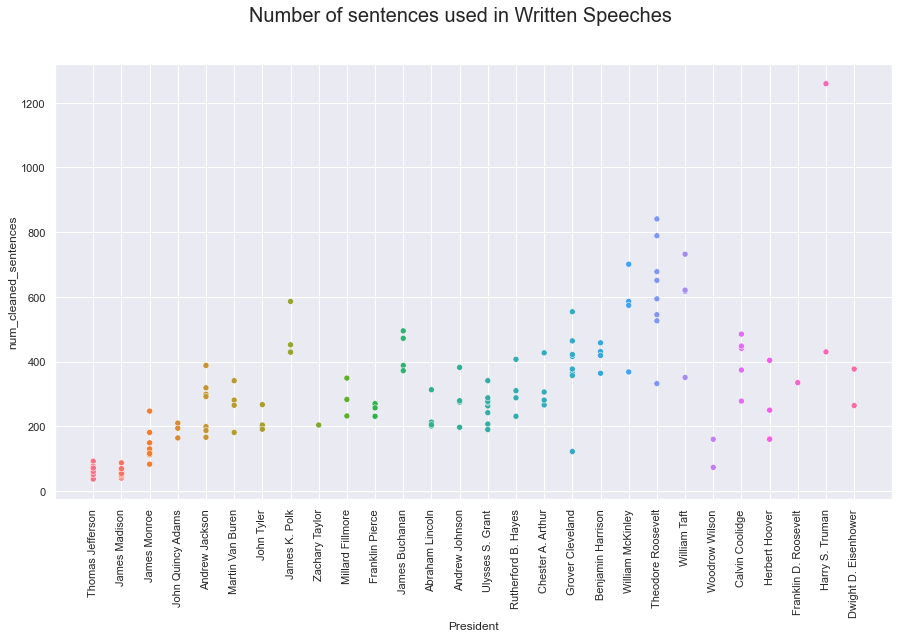

In [656]:
plt.figure(figsize = (15,8))
ax=sns.scatterplot(data=major_speeches_df[major_speeches_df["Speech_Type"]=="written"], x="President", y="num_cleaned_sentences", hue="President", legend=False)
ax.tick_params(axis='x', rotation=90)
plt.suptitle('Number of sentences used in Written Speeches', fontsize=20)


Text(0.5, 0.98, 'Number of sentences used in Oral Speeches')

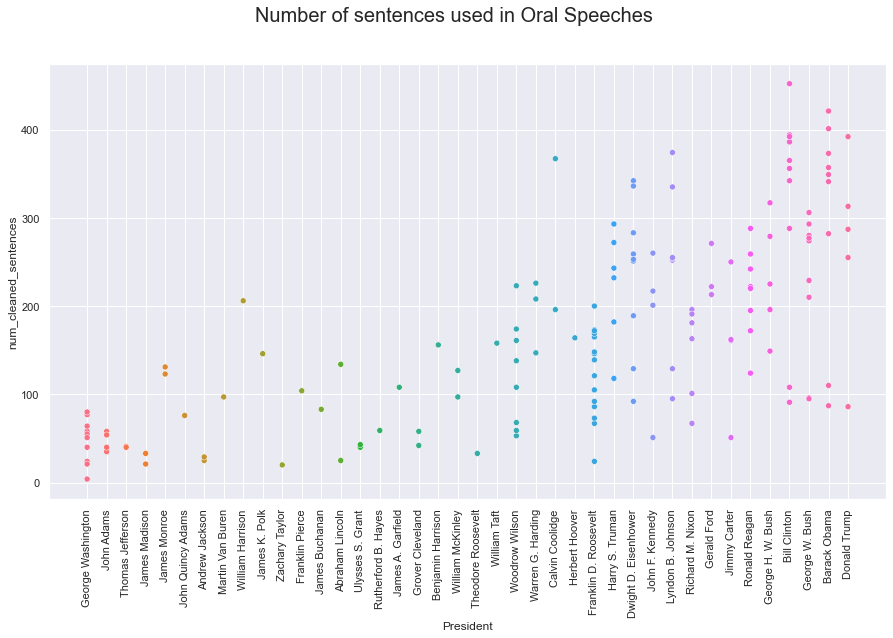

In [658]:
plt.figure(figsize = (15,8))
ax=sns.scatterplot(data=major_speeches_df[major_speeches_df["Speech_Type"]=="oral"], x="President", y="num_cleaned_sentences", hue="President", legend=False)
ax.tick_params(axis='x', rotation=90)
plt.suptitle('Number of sentences used in Oral Speeches', fontsize=20)

<a name =stepb7></a>
## B7. Number of Words per Sentence

Both in written and oral speeches there is a significant decline in the number of words per sentence which reflects societal change in language over time.

[Go to top](#top)

In [701]:
major_speeches_df["word_p_sen"]= major_speeches_df["speech_length"]/major_speeches_df["num_cleaned_sentences"]

Text(0.5, 0.98, 'Word used per sentence in Written Speeches')

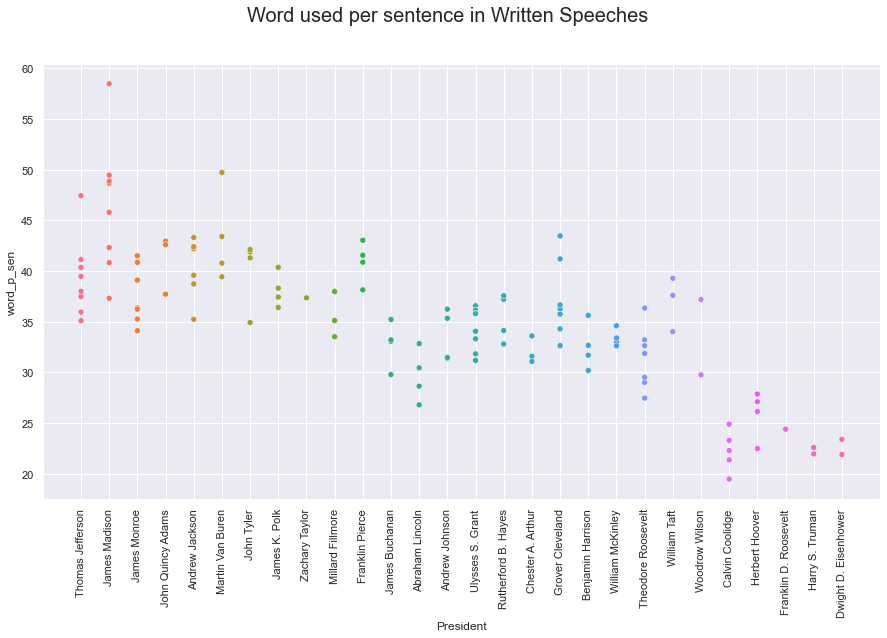

In [704]:
plt.figure(figsize = (15,8))
ax=sns.scatterplot(data=major_speeches_df[major_speeches_df["Speech_Type"]=="written"], x="President", y="word_p_sen", hue="President", legend=False)
ax.tick_params(axis='x', rotation=90)
plt.suptitle('Word used per sentence in Written Speeches', fontsize=20)

Text(0.5, 0.98, 'Word used per sentence in Oral Speeches')

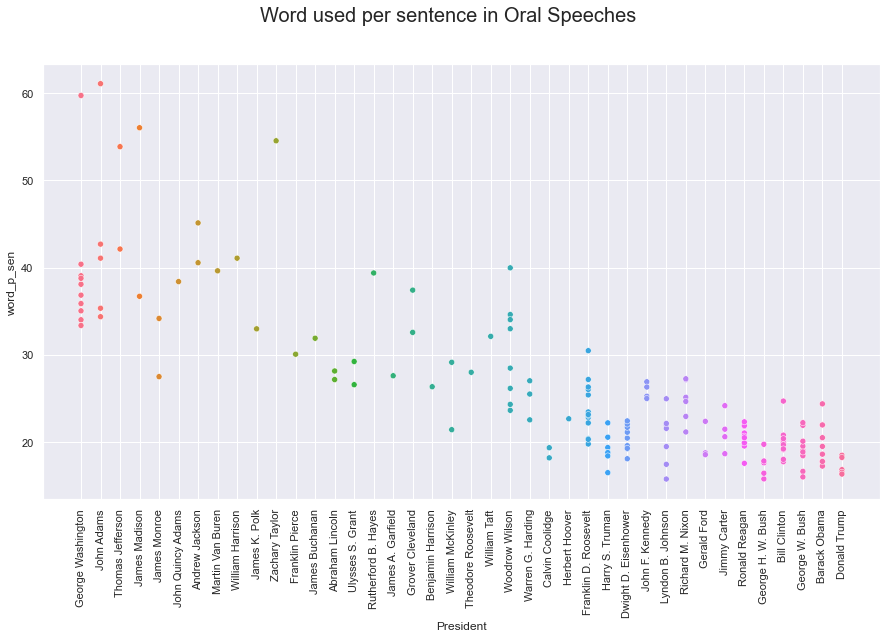

In [702]:
plt.figure(figsize = (15,8))
ax=sns.scatterplot(data=major_speeches_df[major_speeches_df["Speech_Type"]=="oral"], x="President", y="word_p_sen", hue="President", legend=False)
ax.tick_params(axis='x', rotation=90)
plt.suptitle('Word used per sentence in Oral Speeches', fontsize=20)

<a name =stepc></a>
    
# PART C: NAME ENTITY RECOGNITION

[Go to top](#top)


<a name =step1></a>
    
# 1. Installing spaCy

[Go to top](#top)

Source: https://towardsdatascience.com/named-entity-recognition-ner-using-spacy-nlp-part-4-28da2ece57c6#:~:text=Spacy%20comes%20with%20an%20extremely,to%20contiguous%20spans%20of%20tokens.&text=Spacy%20provides%20an%20option,defined%20entities%20within%20the%20model.

In [ ]:
#Install Spacy
pip install -U pip setuptools wheel pip install -U spacy

In [ ]:
#download a trained pipeline
!python -m spacy download en_core_web_md 

In [ ]:
#install packages in a virtual environment to avoid any modification of the system state.
!python -m venv .env
!source .env/bin/activate
!pip install -U pip setuptools wheel
!pip install -U spacy

<a name =step2></a>
    
# 2. Import spaCy

[Go to top](#top)


In [685]:
import spacy
from spacy import displacy
nlp=spacy.load('en_core_web_md')

## Function to display basic entity info:

In [686]:
def show_ents(doc): 
    if doc.ents: 
        for ent in doc.ents: 
            print(ent.text+' - ' +str(ent.start_char) +' - '+ str(ent.end_char) +' - '+ent.label_+ ' - '+str(spacy.explain(ent.label_))) 
    else: 
        print('No named entities found.')

#### Let's try for 1 president

<a name =step3></a>
    
# 3. Named Entity Recognition

[Go to top](#top)

In [687]:
for i in range(5):#major_speeches_df.shape[0]
    speech=(major_speeches_df.Transcript.iloc[i])
    doc = nlp(speech)
    show_ents(doc)

Senate - 23 - 29 - ORG - Companies, agencies, institutions, etc.
the House of Representatives - 34 - 62 - ORG - Companies, agencies, institutions, etc.
the fourteenth day - 241 - 259 - DATE - Absolute or relative dates or periods
years - 540 - 545 - DATE - Absolute or relative dates or periods
first - 2063 - 2068 - ORDINAL - "first", "second", etc.
Act - 2078 - 2081 - PERSON - People, including fictional
Universe - 2150 - 2158 - PERSON - People, including fictional
the Councils of Nations - 2176 - 2199 - ORG - Companies, agencies, institutions, etc.
the People of the United States - 2330 - 2361 - ORG - Companies, agencies, institutions, etc.
the United States - 2894 - 2911 - GPE - Countries, cities, states
United Government - 3140 - 3157 - ORG - Companies, agencies, institutions, etc.
the Executive Department - 3806 - 3830 - ORG - Companies, agencies, institutions, etc.
the Great Constitutional Charter - 4083 - 4115 - LAW - Named documents made into laws.
one - 4637 - 4640 - CARDINAL -

Senate - 23 - 29 - ORG - Companies, agencies, institutions, etc.
the House of Representatives - 38 - 66 - ORG - Companies, agencies, institutions, etc.
Indian - 286 - 292 - NORP - Nationalities or religious or political groups
North Western - 351 - 364 - LOC - Non-GPE locations, mountain ranges, bodies of water
Massacre - 1900 - 1908 - PERSON - People, including fictional
North - 2191 - 2196 - LOC - Non-GPE locations, mountain ranges, bodies of water
Ohio - 2204 - 2208 - GPE - Countries, cities, states
Cherokees - 2309 - 2318 - ORG - Companies, agencies, institutions, etc.
Chickamagas - 2341 - 2352 - GPE - Countries, cities, states
five - 2367 - 2371 - CARDINAL - Numerals that do not fall under another type
the Tennesee River - 2384 - 2402 - LOC - Non-GPE locations, mountain ranges, bodies of water
Holstin - 2527 - 2534 - PERSON - People, including fictional
Cherokee - 2550 - 2558 - PRODUCT - Objects, vehicles, foods, etc. (not services)
July 1791 - 2569 - 2578 - DATE - Absolute or rel

### Identifying entities that are related to geo-politics

In [688]:
colors = {'NORP': 'linear-gradient(90deg, #aa9cde, #dc9ce7)', 'LOC': 'radial-gradient(white, red)', 'GPE': 'radial-gradient(white, red)'}
options ={'ents': ['NORP','LOC','GPE'],'colors':colors}


for i in range(2):#major_speeches_df.shape[0]
    speech=(major_speeches_df.Transcript.iloc[i])
    doc = nlp(speech)
    displacy.render(doc,style='ent', jupyter=True, options=options)
    

In [689]:
geo_entities_list=[]

for i in range(major_speeches_df.shape[0]):#major_speeches_df.shape[0]
    speech=(major_speeches_df.Transcript.iloc[i])
    doc = nlp(speech)
    #print([{ent: ent.label_} for ent in doc.ents if ent.label_=='NORP' or ent.label_=='LOC' or ent.label_=='GPE'])
    geo_entities = [str(ent) for ent in doc.ents if ent.label_=='GPE'] 
    c_geo = Counter(geo_entities)
    geo_entities_dict=dict(c_geo)
    geo_entities_list.append(geo_entities_dict)
    
major_speeches_df["geo_priorities"]=geo_entities_list
major_speeches_df

,Date,President,President No.,Party,Speech Title,Speech_Type,Summary,Transcript,URL,characters,speech_length,cleaned_words,Sentences,num_sentences,cleaned_sentences,num_cleaned_sentences,transcripts_new,common_sentences,geo_priorities
0,1789-04-30,George Washington,1,Unaffiliated,First Inaugural Address,oral,Washington calls on Congress to avoid local an...,Fellow Citizens of the Senate and the House of...,https://millercenter.org/the-presidency/presid...,8677,1434,"{'the': 117, 'of': 70, 'and': 48, 'to': 48, 'w...",[Fellow Citizens of the Senate and the House o...,24,[fellow citizens of the senate and the house o...,24,[fellow senate house representative among vici...,{'fellow citizens of the senate and the house ...,{'the United States': 1}
1,1790-01-08,George Washington,1,Unaffiliated,First Annual Message to Congress,oral,"In a wide ranging speech, President Washington...",Fellow Citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,5282,848,"{'the': 76, 'of': 53, 'to': 42, 'and': 31, 'be...",[Fellow Citizens of the Senate and House of Re...,21,[fellow citizens of the senate and house of re...,21,[fellow senate house representative embrace sa...,{'fellow citizens of the senate and house of r...,{'the United States': 3}
2,1790-12-08,George Washington,1,Unaffiliated,Second Annual Message to Congress,oral,Washington focuses on commerce in his second a...,Fellow citizens of the Senate and House of Rep...,https://millercenter.org/the-presidency/presid...,8377,1401,"{'the': 120, 'of': 90, 'to': 49, 'and': 44, 'i...",[Fellow citizens of the Senate and House of Re...,40,[fellow citizens of the senate and house of re...,40,[fellow senate house representative meeting ag...,{'fellow citizens of the senate and house of r...,"{'Holland': 1, 'the District of Kentucky': 1, ..."
3,1791-10-25,George Washington,1,Unaffiliated,Third Annual Message to Congress,oral,Washington praises the success of the new bank...,"I meet you, upon the present occasion, with th...",https://millercenter.org/the-presidency/presid...,13938,2265,"{'the': 237, 'of': 156, 'to': 88, 'and': 73, '...","[I meet you, upon the present occasion, with t...",58,[i meet you upon the present occasion with the...,58,[meet occasion feeling naturally inspired stro...,{'i meet you upon the present occasion with th...,"{'the United States': 15, 'Alexandria': 1, 'Ho..."
4,1792-11-06,George Washington,1,Unaffiliated,Fourth Annual Message to Congress,oral,NaN,"Fellow Citizens of the Senate, and of the Hous...",https://millercenter.org/the-presidency/presid...,14226,2357,"{'the': 215, 'of': 153, 'to': 101, 'and': 61, ...","[Fellow Citizens of the Senate, and of the Hou...",64,[fellow citizens of the senate and of the hous...,64,[fellow senate house representative abatement ...,{'fellow citizens of the senate and of the hou...,"{'Ohio': 1, 'Chickamagas': 2, 'the United Stat..."
5,1793-03-04,George Washington,1,Unaffiliated,Second Inaugural Address,oral,"In a simple, brief speech, Washington expresse...",Fellow Citizens: I am again called upon by the...,https://millercenter.org/the-presidency/presid...,791,136,"{'the': 13, 'of': 11, 'i': 6, 'to': 5, 'shall'...",[Fellow Citizens: I am again called upon by th...,4,[fellow citizens i am again called upon by the...,4,[fellow am again called voice execute function...,{'fellow citizens i am again called upon by th...,{}
6,1793-12-03,George Washington,1,Unaffiliated,Fifth Annual Message to Congress,oral,Devoting much of his message to foreign affair...,Fellow Citizens of the Senate and of the House...,https://millercenter.org/the-presidency/presid...,11464,1834,"{'the': 162, 'of': 122, 'to': 64, 'and': 42, '...",[Fellow Citizens of the Senate and of the Hous...,55,[fellow citizens of the senate and of the hous...,55,"[fellow senate house representative, since com...",{'fellow citizens of the senate and of the hou...,"{'States': 4, 'the United States': 13, 'France..."
7,1794-11-19,George Washington,1,Unaffi

In [694]:
major_speeches_df["geo_priorities"][4]

{'Ohio': 1,
 'Chickamagas': 2,
 'the United States': 2,
 'Virginia': 1,
 'Kentucky': 1,
 'Antwerp': 1,
 'Amsterdam': 1}

## Create a dictionary with data to export

In [ ]:
geo_export_list=[]
for i in range(len(major_speeches)):
    {'date': major_speeches_df["Date"], 'president': major_speeches_df["Date"], 'geo_pol': 200}

In [700]:
major_speeches_df.to_csv('geo_priorities_test.csv')

In [699]:
major_speeches_df["geo_priorities"]

0                               {'the United States': 1}
1                               {'the United States': 3}
2      {'Holland': 1, 'the District of Kentucky': 1, ...
3      {'the United States': 15, 'Alexandria': 1, 'Ho...
4      {'Ohio': 1, 'Chickamagas': 2, 'the United Stat...
5                                                     {}
6      {'States': 4, 'the United States': 13, 'France...
7      {'the United States': 14, 'States': 1, 'Pennsy...
8      {'Ohio': 1, 'the United States': 5, 'Georgia':...
9      {'Colerain': 1, 'the State of Georgia': 1, 'th...
10                           {'America': 5, 'States': 5}
11     {'Philadelphia': 3, 'Holland': 2, 'Paris': 1, ...
12     {'States': 1, 'the United States': 12, 'France...
13     {'the United States of America': 1, 'Pennsylva...
14     {'Philadelphia': 1, 'the United States': 6, 't...
15                                     {'Providence': 1}
16     {'Tripoli': 1, 'the Barbary States': 1, 'Gibra...
17     {'the United States': 2,

<a name =step4></a>
    
# 3. Bar Char Race

See Chart here: https://observablehq.com/d/93f06585b99b7bf9

I compared the frequency of geo-related entities between Obama and Trump. The bar chart race shows the differences in utilization of words between Obama (2nd term) and Trump.
- America vs United States
-  Ukraine vs Russia
- Middle East vs Asia
- Global Priorities vs Domestic Priorities

[Go to top](#top)